In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery

img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [10]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [11]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform) # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform)
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [12]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [13]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [14]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

In [15]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

### call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 8 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
model = unet11(pretrained=False)

# set some parameters
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
## GT
# num_workers=0 seems to engage all GPUs, where previously 4 worked
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False, num_workers=0)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False, num_workers=0)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False, num_workers=0)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False, num_workers=0)


# record time for one epoch
rocs = []
t0 = time.time()
for epoch in range(100):
    te = time.time()
    
    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))
    tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
    for i, (inputs_, targets_) in enumerate(tl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = model(inputs)

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()
        step+=1


        if i%20 == 0: # print/store every 10
            losses.append(i_loss)
            #running_loss += i_loss
            #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))
    
    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
        rocs.append(tu[1])

    losses_ep.append(losses)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))
    
    # early exit criteria
    if len(rocs)>2:
        if (np.abs(rocs[-1] - rocs[-2]) < 0.009) and (rocs[-1] > 0.98):
            print('area under curve not changing significantly, exit loop')
            break_flag = True
            break

t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Let's use 4 GPUs!
batchsize,  8
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 1318.3426866531372 seconds
on epoch 2
epoch: 2, LOSS=0.9892442226409912, ROC_AUC=0.8697259044196497 
time for epoch 2: 539.7752294540405 seconds
on epoch 3
time for epoch 3: 539.7790846824646 seconds
on epoch 4
epoch: 4, LOSS=0.8182443380355835, ROC_AUC=0.9048158973665801 
time for epoch 4: 540.353257894516 seconds
on epoch 5
time for epoch 5: 539.8714063167572 seconds
on epoch 6
epoch: 6, LOSS=0.7113008499145508, ROC_AUC=0.9268690816545675 
time for epoch 6: 540.4657642841339 seconds
on epoch 7
time for epoch 7: 539.7858741283417 seconds
on epoch 8
epoch: 8, LOSS=0.6203255653381348, ROC_AUC=0.9437399062197648 
time for epoch 8: 540.8695888519287 seconds
on epoch 9
time for epoch 9: 540.050853729248 seconds
on epoch 10
epoch: 10, LOSS=0.5444697141647339, ROC_AUC=0.9568814093170487 
time for epoch 10: 540.6630163192749 seconds
on epoch 11
time for epoch 11: 539.6551539897919 seconds
on epoch 12
epoch: 12, LOSS=0.49602991342544556, ROC_AUC=0.963806632872807 
time for ep

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


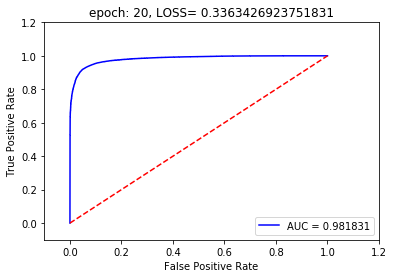

In [16]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [17]:
model.eval()

DataParallel(
  (module): UNet11(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Validation batch: 0, LOSS=0.47241896390914917, ROC_AUC=0.9633223552702475 


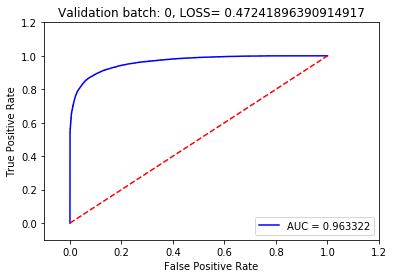

Validation batch: 1, LOSS=0.523982048034668, ROC_AUC=0.9592465191463255 


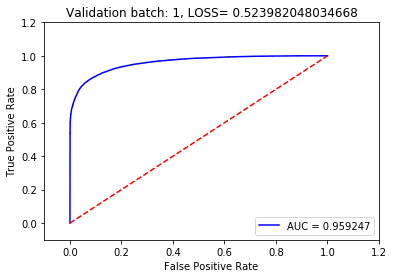

Validation batch: 2, LOSS=0.3343451917171478, ROC_AUC=0.9762896713231375 


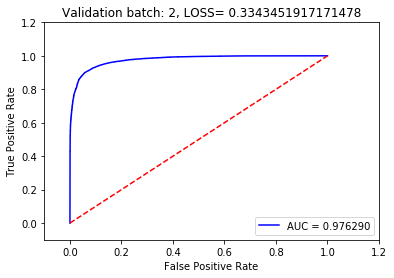

Validation batch: 3, LOSS=0.6805579662322998, ROC_AUC=0.9346684690981673 


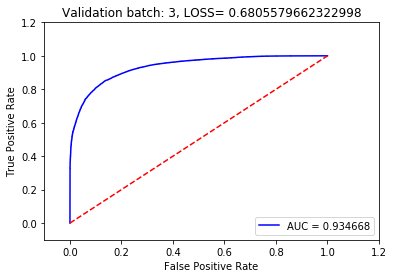

Validation batch: 4, LOSS=0.37201011180877686, ROC_AUC=0.974510023393982 


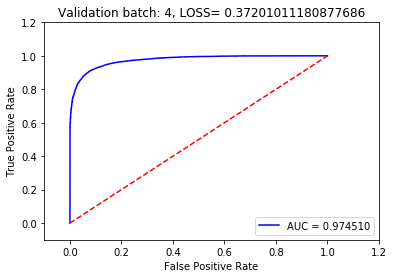

Validation batch: 5, LOSS=0.5033028721809387, ROC_AUC=0.9554690729255202 


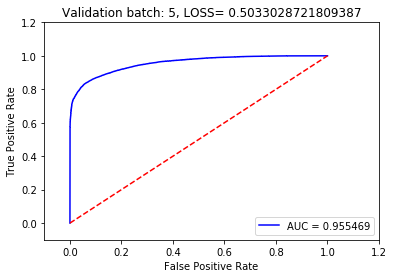

Validation batch: 6, LOSS=0.5548627376556396, ROC_AUC=0.9588362206012089 


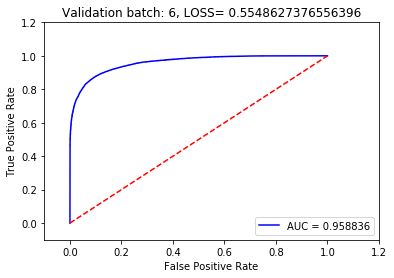

Validation batch: 7, LOSS=0.41821879148483276, ROC_AUC=0.9630914605798062 


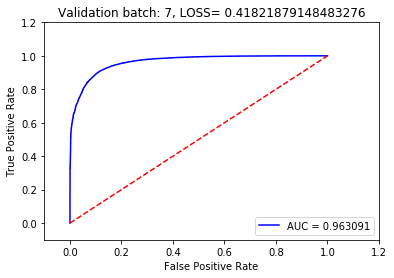

Validation batch: 8, LOSS=0.4831571877002716, ROC_AUC=0.9617825466408401 


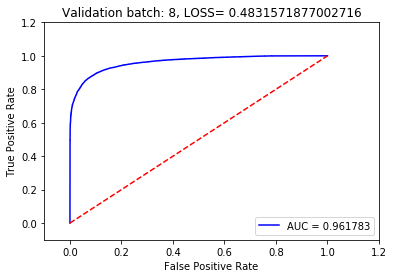

Validation batch: 9, LOSS=0.47891366481781006, ROC_AUC=0.9611066011611382 


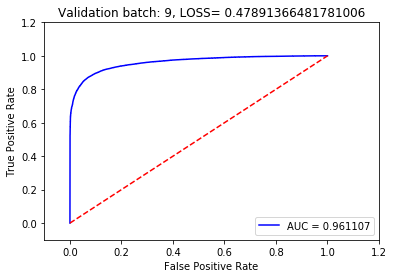

Validation batch: 10, LOSS=0.7079005241394043, ROC_AUC=0.9332373174839368 


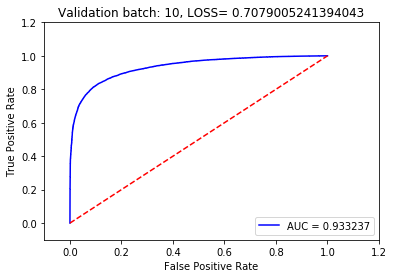

Validation batch: 11, LOSS=0.37455618381500244, ROC_AUC=0.9680535705309984 


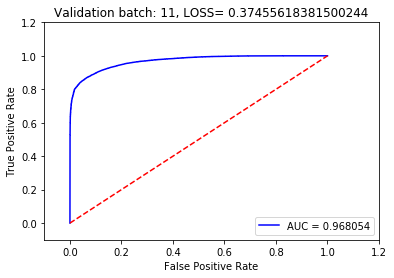

Validation batch: 12, LOSS=0.4167556166648865, ROC_AUC=0.9740284484333255 


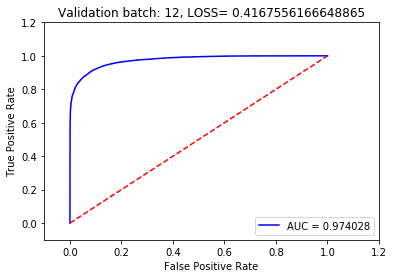

Validation batch: 13, LOSS=0.52491295337677, ROC_AUC=0.9541318207229134 


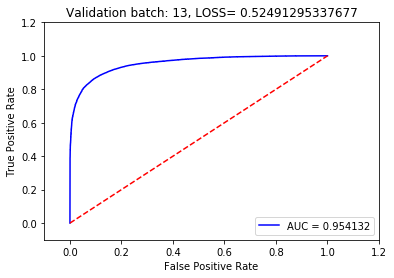

Validation batch: 14, LOSS=0.6723989248275757, ROC_AUC=0.9431193752752604 


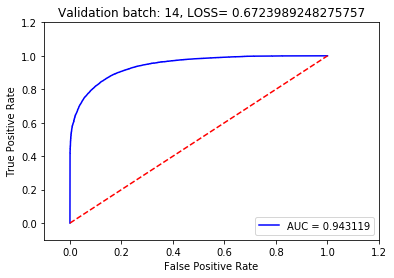

Validation batch: 15, LOSS=0.5515305399894714, ROC_AUC=0.9566628775162227 


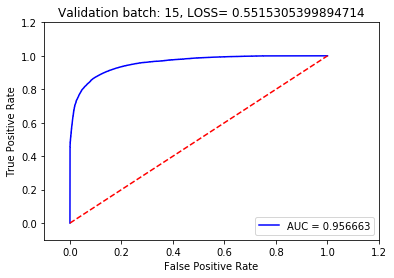

Validation batch: 16, LOSS=0.5678621530532837, ROC_AUC=0.9507824631781575 


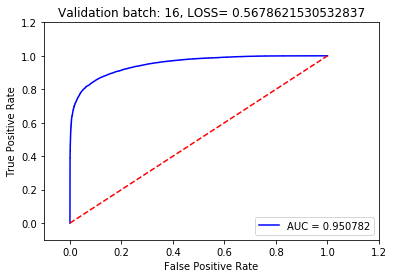

Validation batch: 17, LOSS=0.6720368266105652, ROC_AUC=0.9423689140001782 


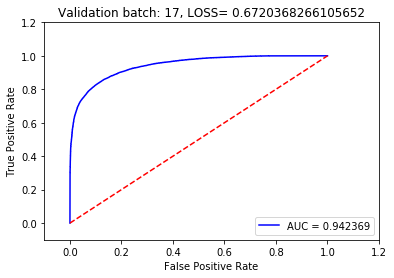

Validation batch: 18, LOSS=0.4938465356826782, ROC_AUC=0.9659561161421403 


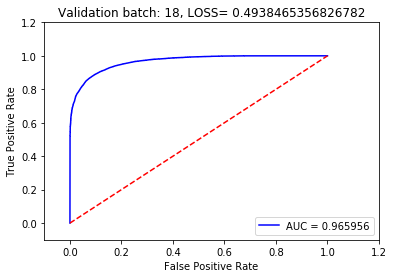

Validation batch: 19, LOSS=0.7696536183357239, ROC_AUC=0.9237501817025788 


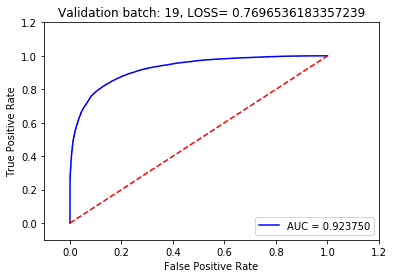

Validation batch: 20, LOSS=0.6006615161895752, ROC_AUC=0.9514368502697663 


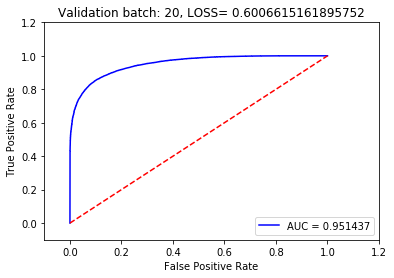

Validation batch: 21, LOSS=0.5740491151809692, ROC_AUC=0.9489588637527318 


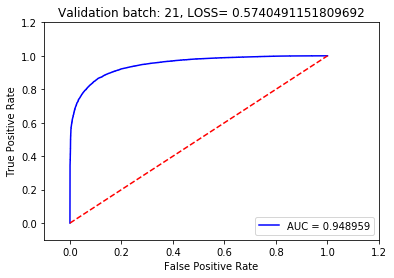

Validation batch: 22, LOSS=0.4480748772621155, ROC_AUC=0.9633292091023707 


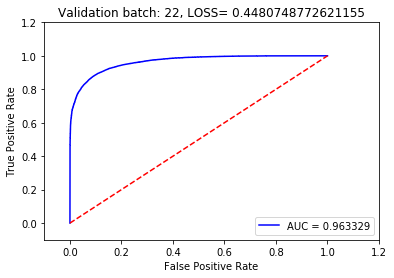

Validation batch: 23, LOSS=0.5885406732559204, ROC_AUC=0.949943918894149 


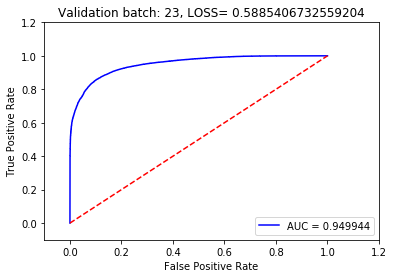

Validation batch: 24, LOSS=0.5581631660461426, ROC_AUC=0.9570492894173519 


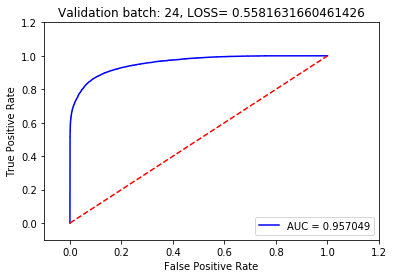

Validation batch: 25, LOSS=0.5592905282974243, ROC_AUC=0.9557780723799478 


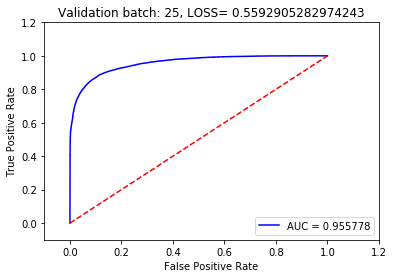

Validation batch: 26, LOSS=0.473789781332016, ROC_AUC=0.9592195678048734 


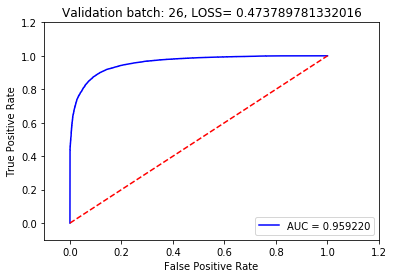

Validation batch: 27, LOSS=0.6097440719604492, ROC_AUC=0.9462434262929879 


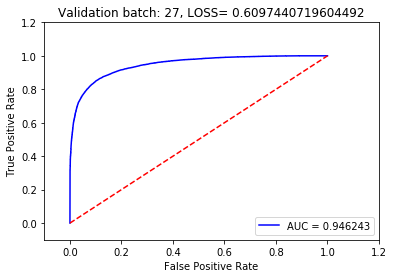

Validation batch: 28, LOSS=0.6470710039138794, ROC_AUC=0.938620586810654 


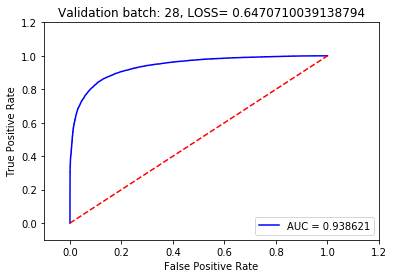

Validation batch: 29, LOSS=0.6057220697402954, ROC_AUC=0.9542684289161637 


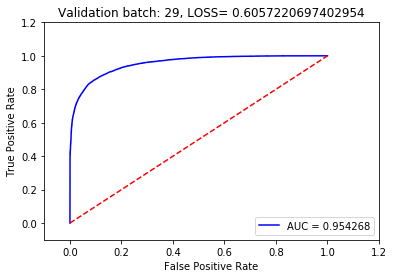

Validation batch: 30, LOSS=0.604309618473053, ROC_AUC=0.9478125850937774 


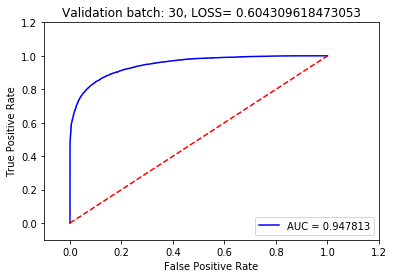

Validation batch: 31, LOSS=0.5680397748947144, ROC_AUC=0.9512449432042077 


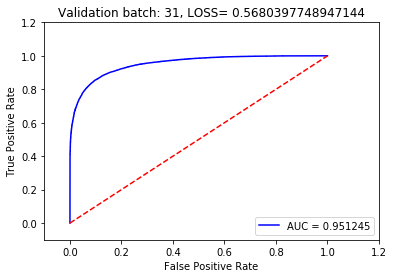

Validation batch: 32, LOSS=0.532820463180542, ROC_AUC=0.9609023900666095 


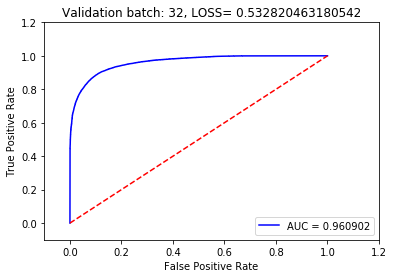

Validation batch: 33, LOSS=0.8363301753997803, ROC_AUC=0.9157265413558892 


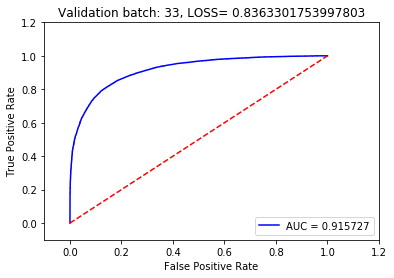

Validation batch: 34, LOSS=0.35973113775253296, ROC_AUC=0.9682036838389962 


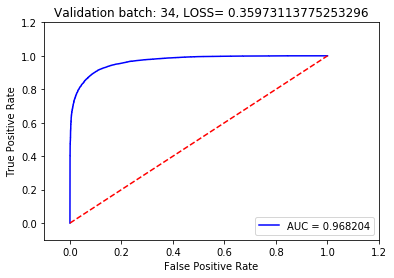

Validation batch: 35, LOSS=0.5762804746627808, ROC_AUC=0.9469995399025014 


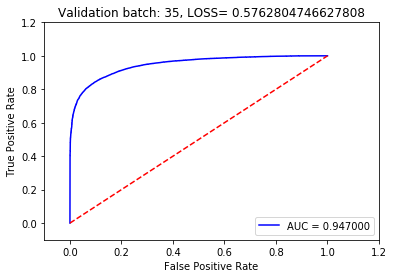

Validation batch: 36, LOSS=0.5577700138092041, ROC_AUC=0.9642365269299054 


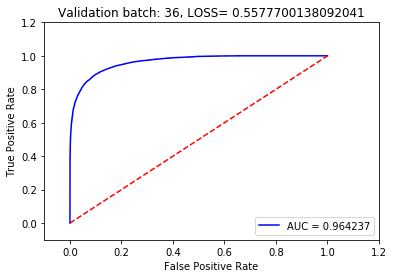

Validation batch: 37, LOSS=0.6055979132652283, ROC_AUC=0.9446327451196967 


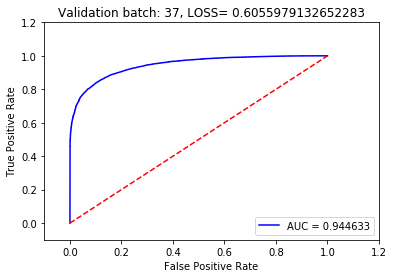

Validation batch: 38, LOSS=0.8225570917129517, ROC_AUC=0.9261707741332952 


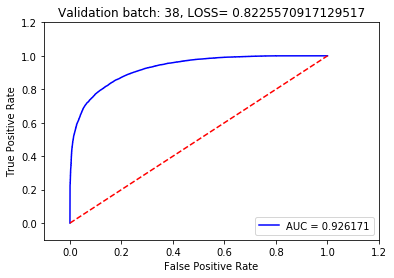

Validation batch: 39, LOSS=0.4065723419189453, ROC_AUC=0.9743158287574487 


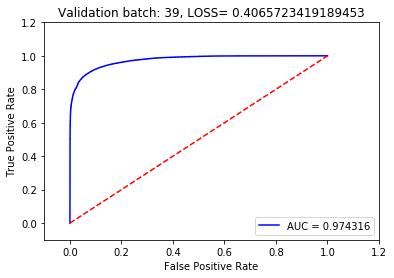

Validation batch: 40, LOSS=0.6497970819473267, ROC_AUC=0.9375533977395364 


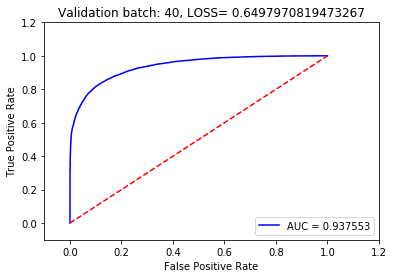

Validation batch: 41, LOSS=0.5342074632644653, ROC_AUC=0.9606531356858958 


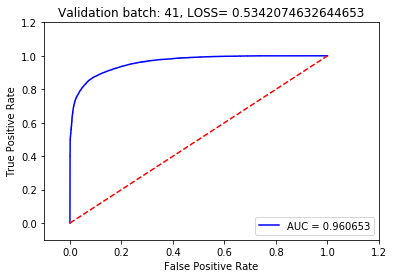

Validation batch: 42, LOSS=0.39285698533058167, ROC_AUC=0.967125674820988 


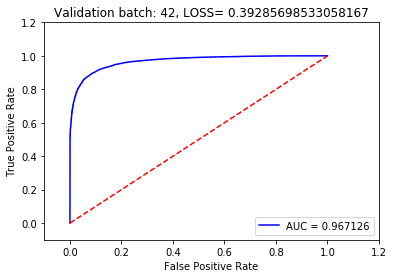

Validation batch: 43, LOSS=0.5976842045783997, ROC_AUC=0.9421762945863222 


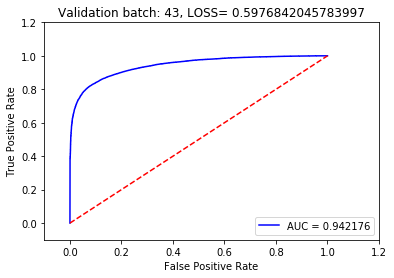

Validation batch: 44, LOSS=0.6166802644729614, ROC_AUC=0.9488185523761103 


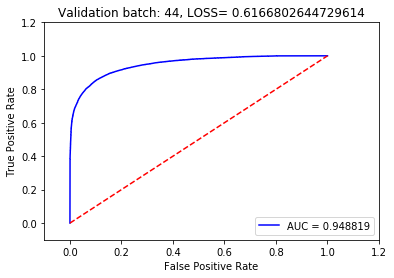

Validation batch: 45, LOSS=0.6613576412200928, ROC_AUC=0.9389140053864531 


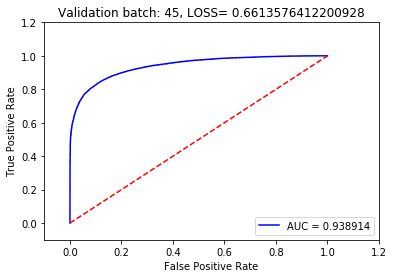

Validation batch: 46, LOSS=0.6003220081329346, ROC_AUC=0.9490066296161438 


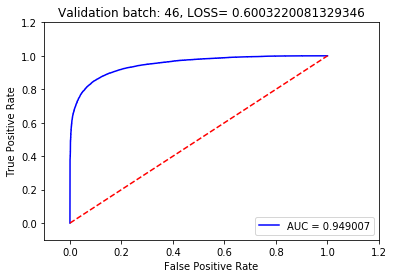

Validation batch: 47, LOSS=0.6215709447860718, ROC_AUC=0.9449963207619928 


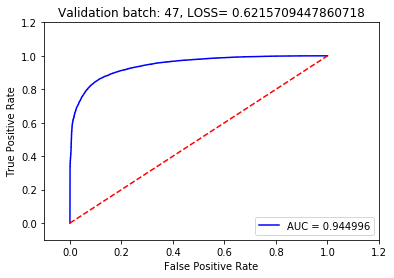

Validation batch: 48, LOSS=0.6353312134742737, ROC_AUC=0.933565179397321 


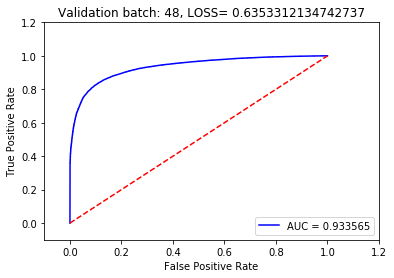

Validation batch: 49, LOSS=0.4696175456047058, ROC_AUC=0.9655082574110363 


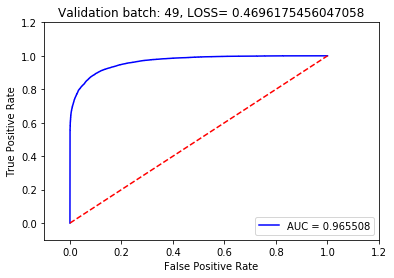

Validation batch: 50, LOSS=0.5065686106681824, ROC_AUC=0.9654308579878326 


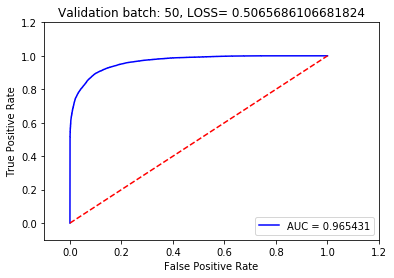

Validation batch: 51, LOSS=0.5494500994682312, ROC_AUC=0.9538798761481566 


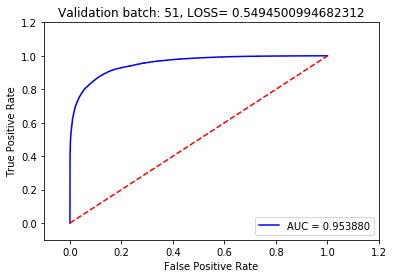

Validation batch: 52, LOSS=0.36974161863327026, ROC_AUC=0.9797434323401499 


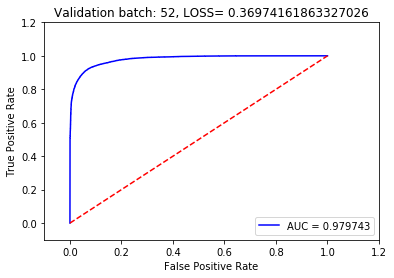

Validation batch: 53, LOSS=0.49855315685272217, ROC_AUC=0.9564882602102452 


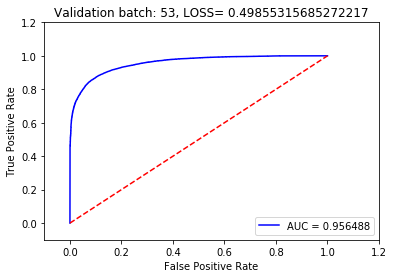

Validation batch: 54, LOSS=0.7925607562065125, ROC_AUC=0.9157941053537607 


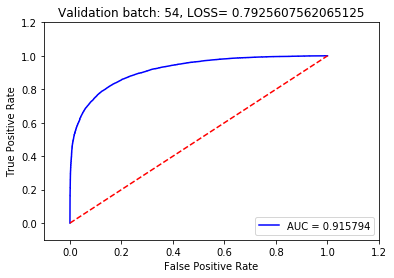

Validation batch: 55, LOSS=0.4953190088272095, ROC_AUC=0.9586509008432433 


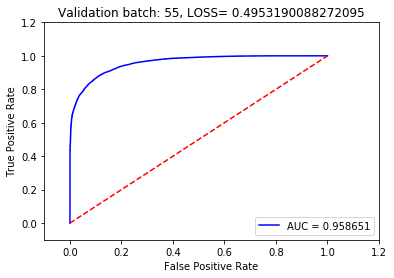

Validation batch: 56, LOSS=0.6083219051361084, ROC_AUC=0.9489172805019208 


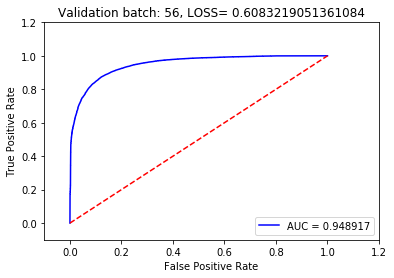

Validation batch: 57, LOSS=0.4413093328475952, ROC_AUC=0.9745072407572383 


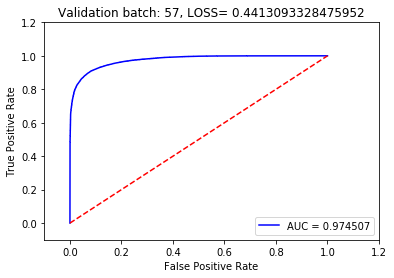

Validation batch: 58, LOSS=0.687879204750061, ROC_AUC=0.9322007272886279 


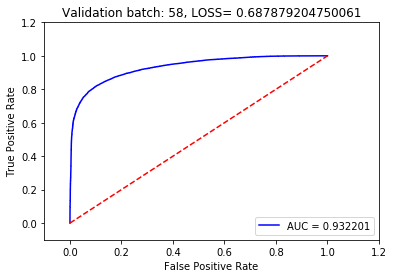

Validation batch: 59, LOSS=0.6081100702285767, ROC_AUC=0.9533661130607045 


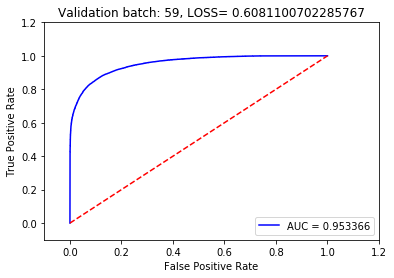

Validation batch: 60, LOSS=0.6778223514556885, ROC_AUC=0.9372182910826464 


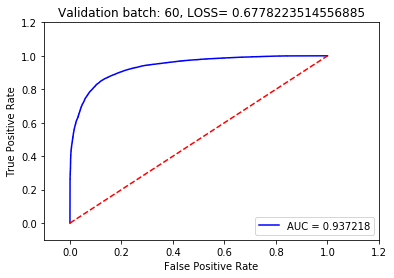

Validation batch: 61, LOSS=0.5429874062538147, ROC_AUC=0.9575352386802429 


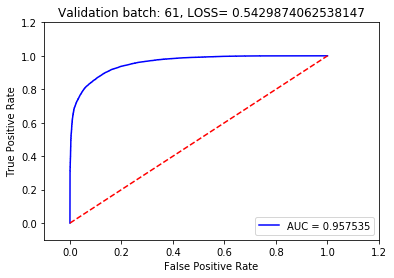

Validation batch: 62, LOSS=0.5271743535995483, ROC_AUC=0.9552455054582971 


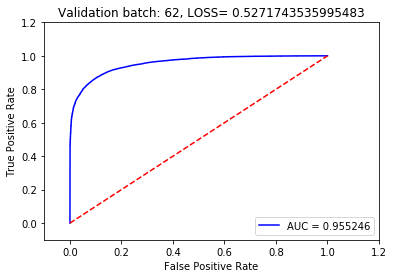

Validation batch: 63, LOSS=0.5467478036880493, ROC_AUC=0.9600799337751589 


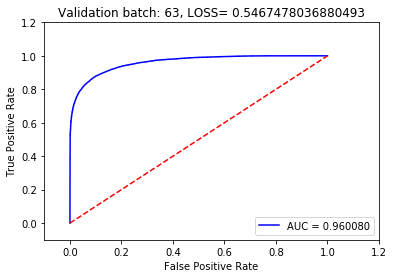

Validation batch: 64, LOSS=0.5759544372558594, ROC_AUC=0.9494795616017887 


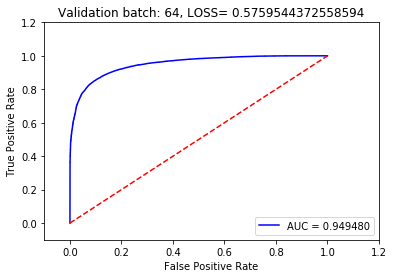

Validation batch: 65, LOSS=0.6741513013839722, ROC_AUC=0.9347164689797259 


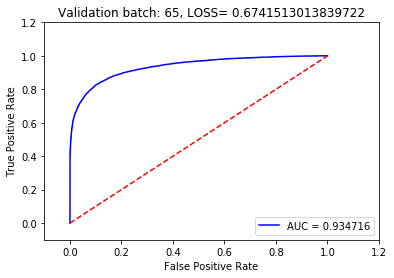

Validation batch: 66, LOSS=0.6664384603500366, ROC_AUC=0.9425429910552572 


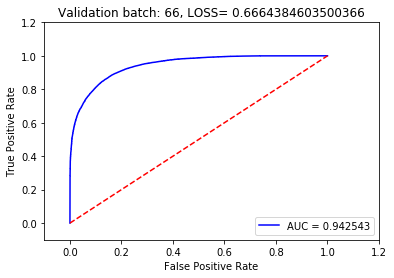

Validation batch: 67, LOSS=0.6878969073295593, ROC_AUC=0.943212189597463 


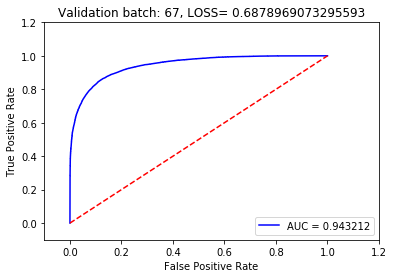

Validation batch: 68, LOSS=0.41114214062690735, ROC_AUC=0.9690018135163607 


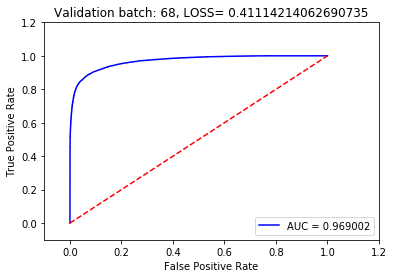

Validation batch: 69, LOSS=0.4930141270160675, ROC_AUC=0.961761154261366 


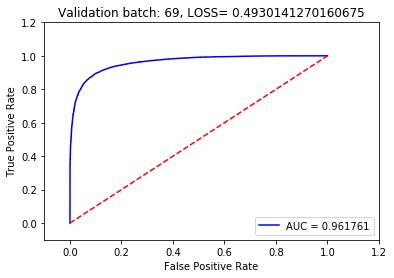

Validation batch: 70, LOSS=0.7585809826850891, ROC_AUC=0.9250557740700847 


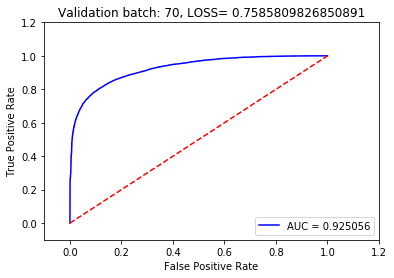

Validation batch: 71, LOSS=0.7337089776992798, ROC_AUC=0.9258724711169382 


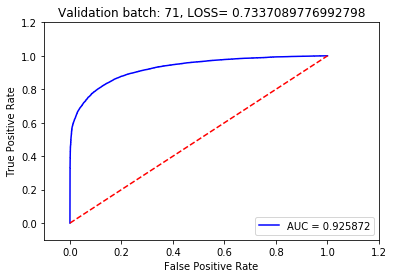

Validation batch: 72, LOSS=0.68211829662323, ROC_AUC=0.9394028475018805 


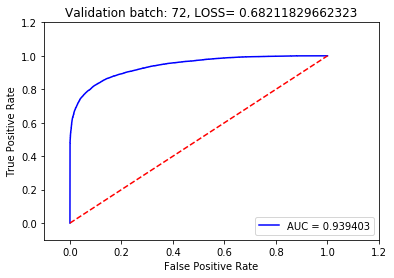

Validation batch: 73, LOSS=0.4844387471675873, ROC_AUC=0.9617400919582155 


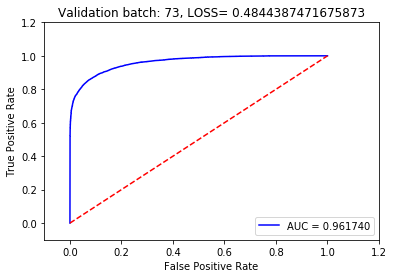

Validation batch: 74, LOSS=0.528301477432251, ROC_AUC=0.9596601771882636 


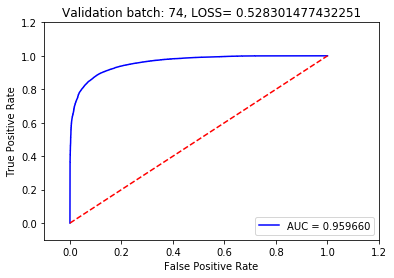

Validation batch: 75, LOSS=0.6243031620979309, ROC_AUC=0.9475597975768377 


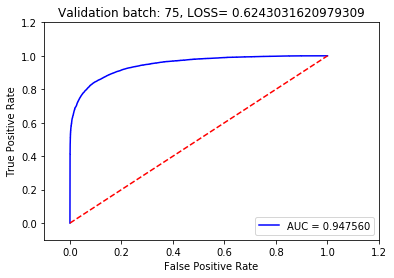

Validation batch: 76, LOSS=0.6527634859085083, ROC_AUC=0.9500674468012403 


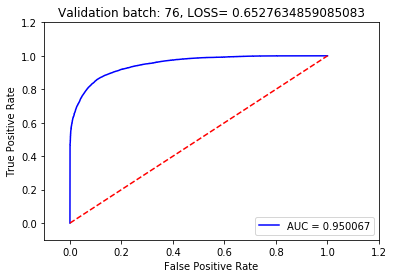

Validation batch: 77, LOSS=0.4700445830821991, ROC_AUC=0.9614650383606875 


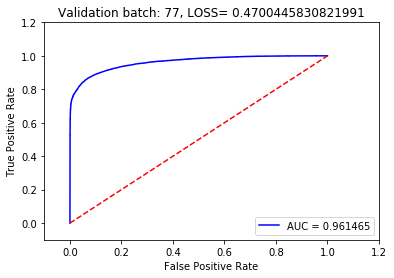

Validation batch: 78, LOSS=0.6373089551925659, ROC_AUC=0.9433303757631177 


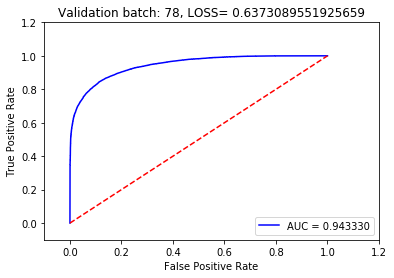

Validation batch: 79, LOSS=0.7447143197059631, ROC_AUC=0.9299996446803557 


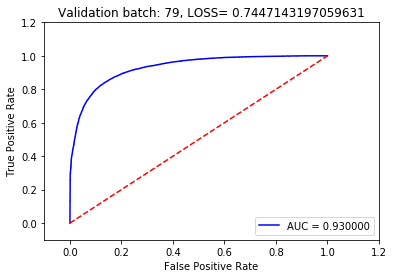

Validation batch: 80, LOSS=0.5000712871551514, ROC_AUC=0.9636264714139707 


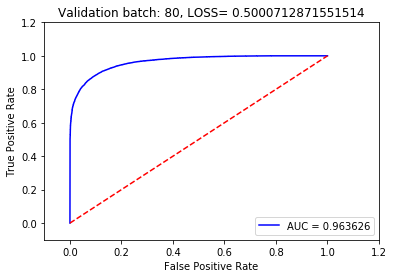

Validation batch: 81, LOSS=0.5311585068702698, ROC_AUC=0.959627416601914 


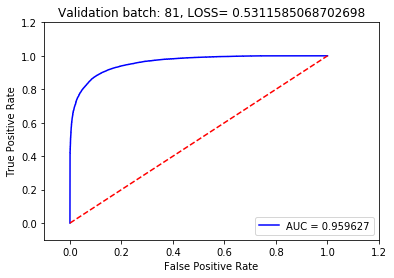

Validation batch: 82, LOSS=0.5271246433258057, ROC_AUC=0.9603913977134018 


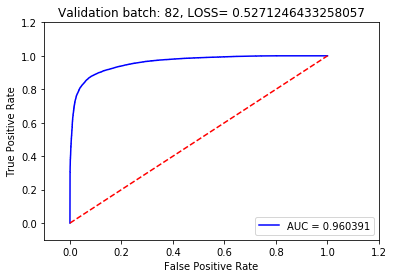

Validation batch: 83, LOSS=0.6309207677841187, ROC_AUC=0.9447480673762813 


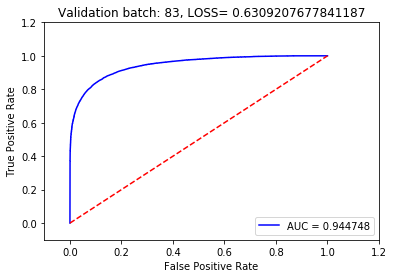

Validation batch: 84, LOSS=0.3365762233734131, ROC_AUC=0.9742513526147971 


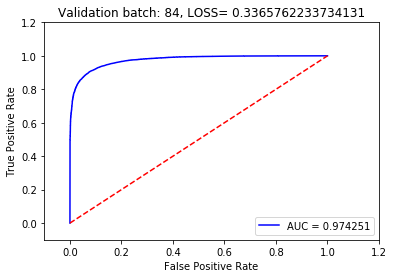

Validation batch: 85, LOSS=0.5533772706985474, ROC_AUC=0.9503633849924977 


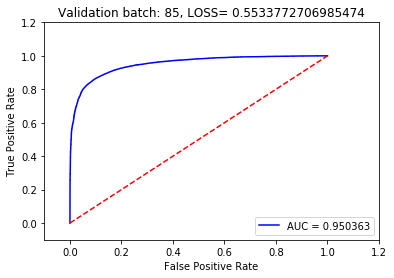

Validation batch: 86, LOSS=0.43744534254074097, ROC_AUC=0.9615918536212323 


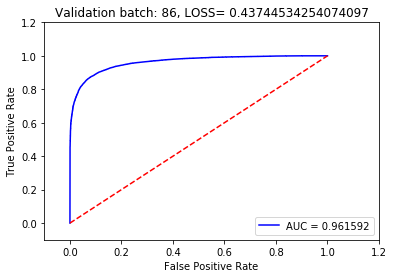

Validation batch: 87, LOSS=0.4309420585632324, ROC_AUC=0.9716299718029829 


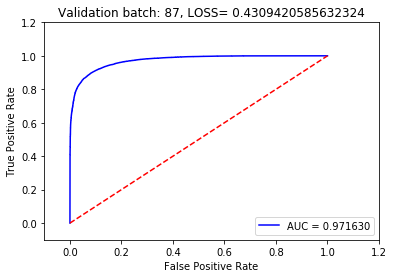

Validation batch: 88, LOSS=0.45625966787338257, ROC_AUC=0.9623624693216595 


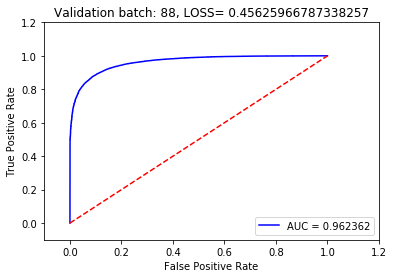

Validation batch: 89, LOSS=0.6962591409683228, ROC_AUC=0.9478861460616785 


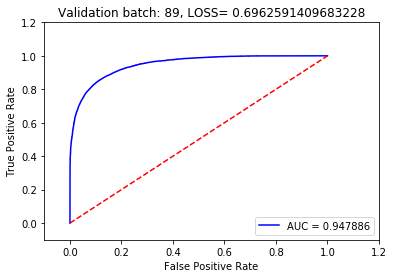

Validation batch: 90, LOSS=0.6069726943969727, ROC_AUC=0.9461217443893332 


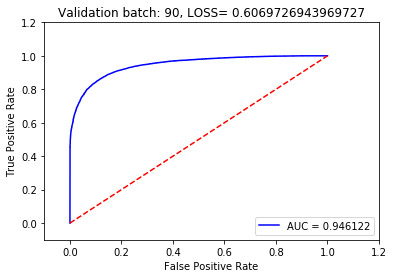

Validation batch: 91, LOSS=0.4348779320716858, ROC_AUC=0.96810630426064 


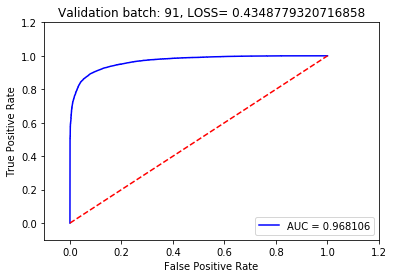

Validation batch: 92, LOSS=0.46769022941589355, ROC_AUC=0.9622032811743557 


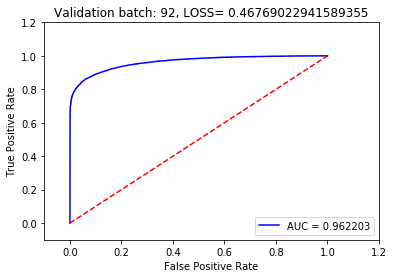

Validation batch: 93, LOSS=0.5140289068222046, ROC_AUC=0.956791275795658 


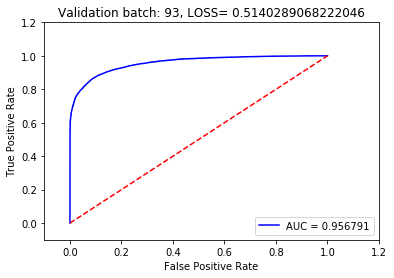

Validation batch: 94, LOSS=0.6225340962409973, ROC_AUC=0.9439785023091405 


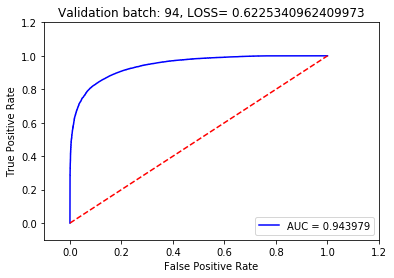

Validation batch: 95, LOSS=0.519718587398529, ROC_AUC=0.9516637349273366 


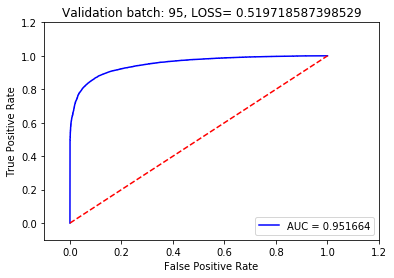

Validation batch: 96, LOSS=0.4738024175167084, ROC_AUC=0.9568063519039522 


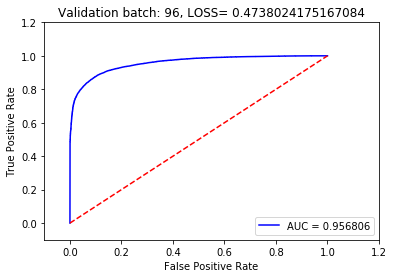

Validation batch: 97, LOSS=0.40062424540519714, ROC_AUC=0.9679988310565762 


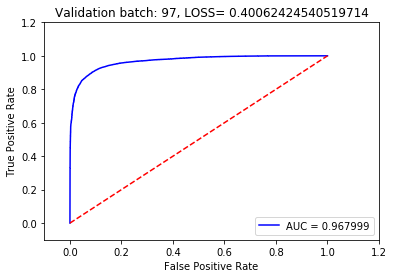

Validation batch: 98, LOSS=0.8895318508148193, ROC_AUC=0.8997311982022942 


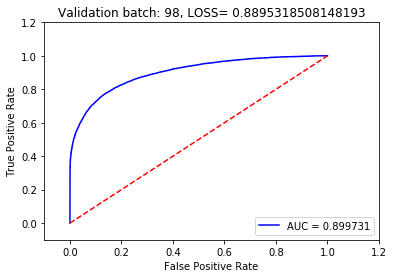

Validation batch: 99, LOSS=0.39951223134994507, ROC_AUC=0.9700034598035147 


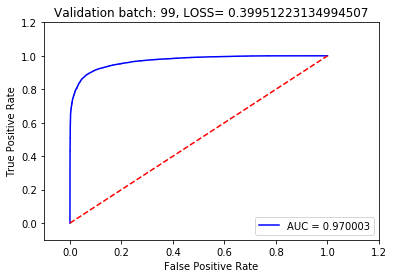

Validation batch: 100, LOSS=0.5354481935501099, ROC_AUC=0.9540462536086032 


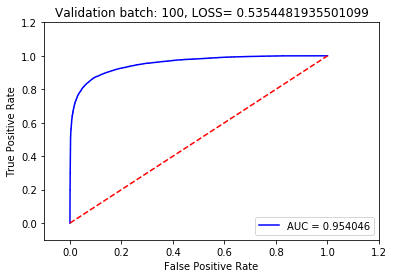

Validation batch: 101, LOSS=0.40082672238349915, ROC_AUC=0.9690107245745445 


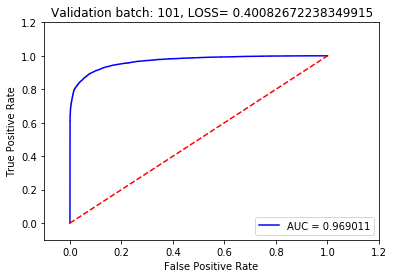

Validation batch: 102, LOSS=0.7910274863243103, ROC_AUC=0.9296496125176062 


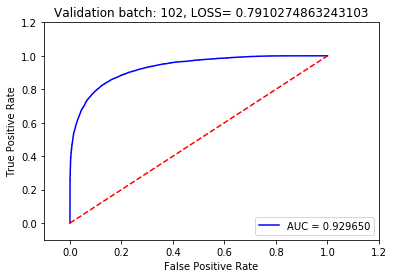

Validation batch: 103, LOSS=0.43935108184814453, ROC_AUC=0.963253335600215 


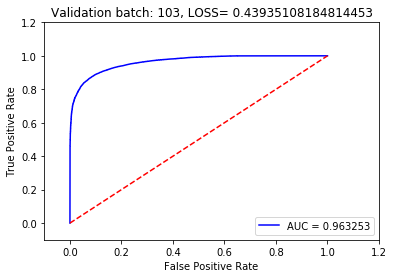

Validation batch: 104, LOSS=0.4618212580680847, ROC_AUC=0.9680355977986684 


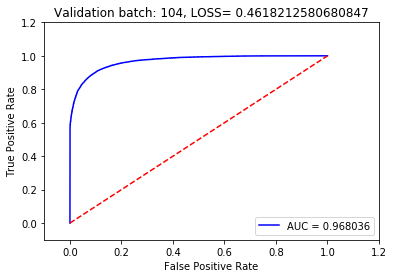

Validation batch: 105, LOSS=0.7952063083648682, ROC_AUC=0.921685904532088 


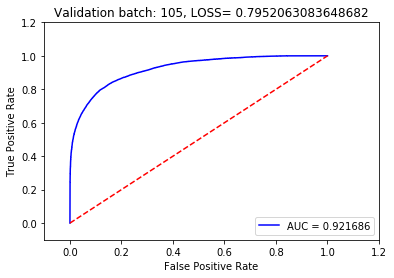

Validation batch: 106, LOSS=0.7707208395004272, ROC_AUC=0.9230294481187081 


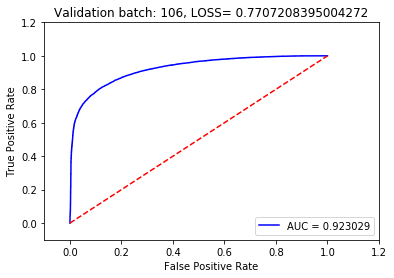

Validation batch: 107, LOSS=0.4572744369506836, ROC_AUC=0.9564230021560983 


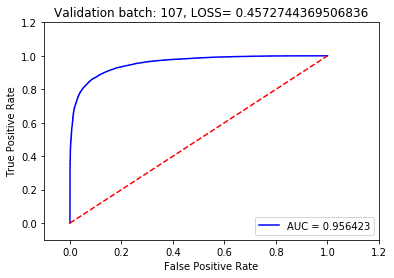

Validation batch: 108, LOSS=0.6681238412857056, ROC_AUC=0.9399859641316607 


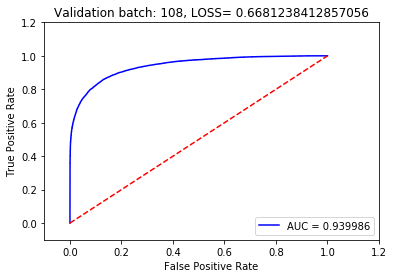

Validation batch: 109, LOSS=0.2781189978122711, ROC_AUC=0.9817876086684214 


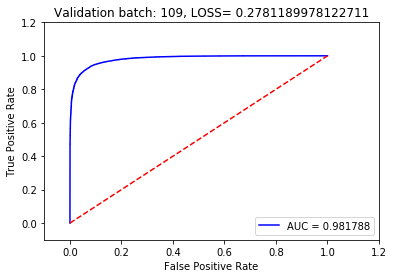

Validation batch: 110, LOSS=0.4163835048675537, ROC_AUC=0.9696650994068714 


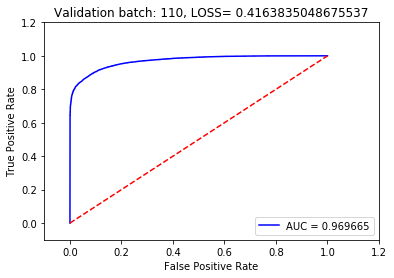

Validation batch: 111, LOSS=0.4614951014518738, ROC_AUC=0.9689503165634757 


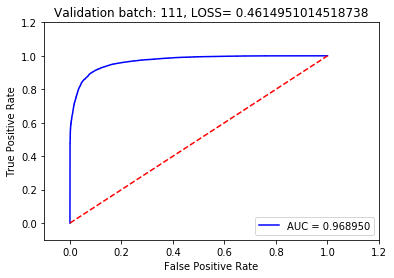

Validation batch: 112, LOSS=0.44636261463165283, ROC_AUC=0.9675948057342745 


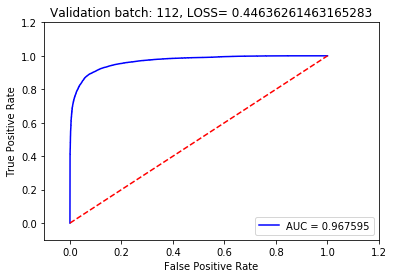

Validation batch: 113, LOSS=0.5608104467391968, ROC_AUC=0.955519574476836 


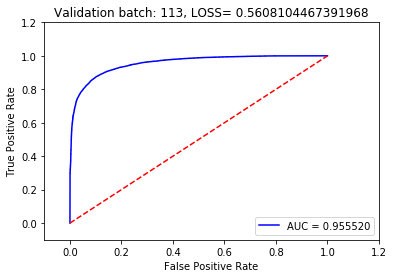

Validation batch: 114, LOSS=0.44467607140541077, ROC_AUC=0.964044703856755 


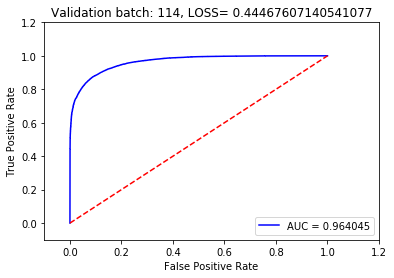

Validation batch: 115, LOSS=0.6182072162628174, ROC_AUC=0.941938972843499 


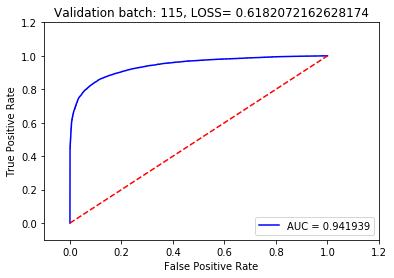

Validation batch: 116, LOSS=0.45375949144363403, ROC_AUC=0.9646794275560064 


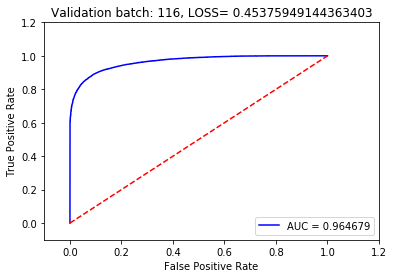

Validation batch: 117, LOSS=0.5007266998291016, ROC_AUC=0.9570747694727235 


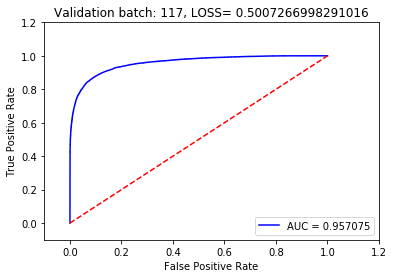

Validation batch: 118, LOSS=0.4974198639392853, ROC_AUC=0.9617920957276288 


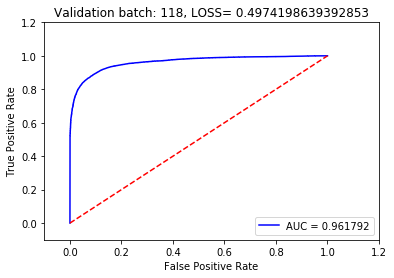

Validation batch: 119, LOSS=0.611385703086853, ROC_AUC=0.943015577080438 


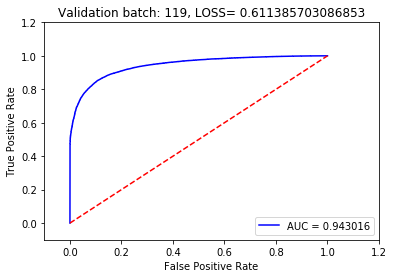

Validation batch: 120, LOSS=0.43563809990882874, ROC_AUC=0.9617510271078586 


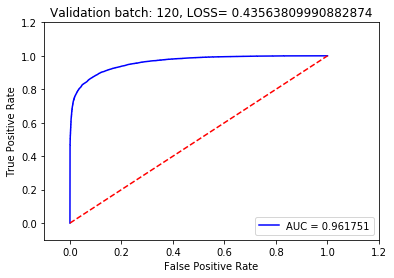

Validation batch: 121, LOSS=0.5190272927284241, ROC_AUC=0.9596792658817975 


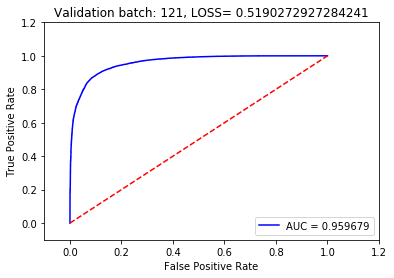

Validation batch: 122, LOSS=0.4620853066444397, ROC_AUC=0.9666925869026652 


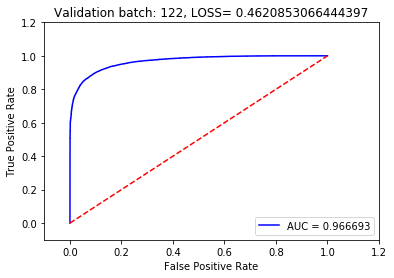

Validation batch: 123, LOSS=0.6175446510314941, ROC_AUC=0.9446622809480096 


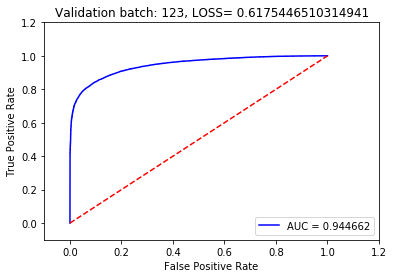

Validation batch: 124, LOSS=0.5221973061561584, ROC_AUC=0.9583326840107513 


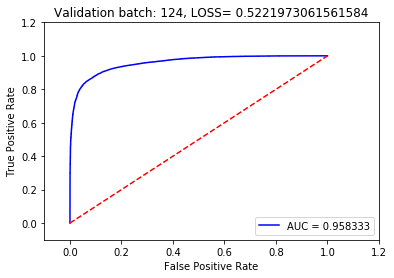

In [18]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


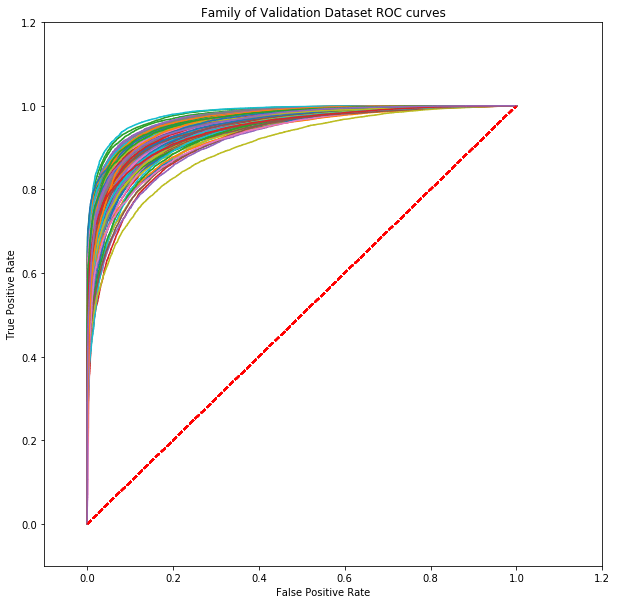

In [19]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


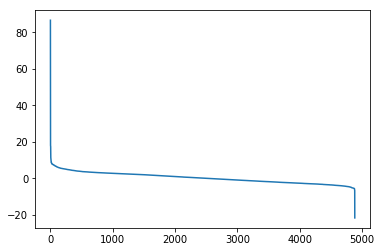

In [20]:
plt.plot(all_thresh[0])

In [21]:
model_path = 'runs/debug/for_paper/BGR_model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


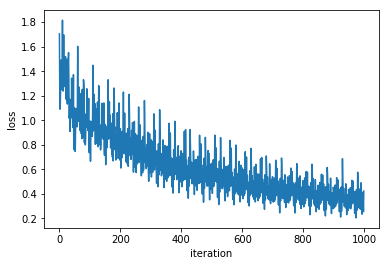

In [22]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.plot([l.data.cpu().numpy() for l in losses])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# plt.plot([l.data.cpu().numpy() for l in losses_ep])
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


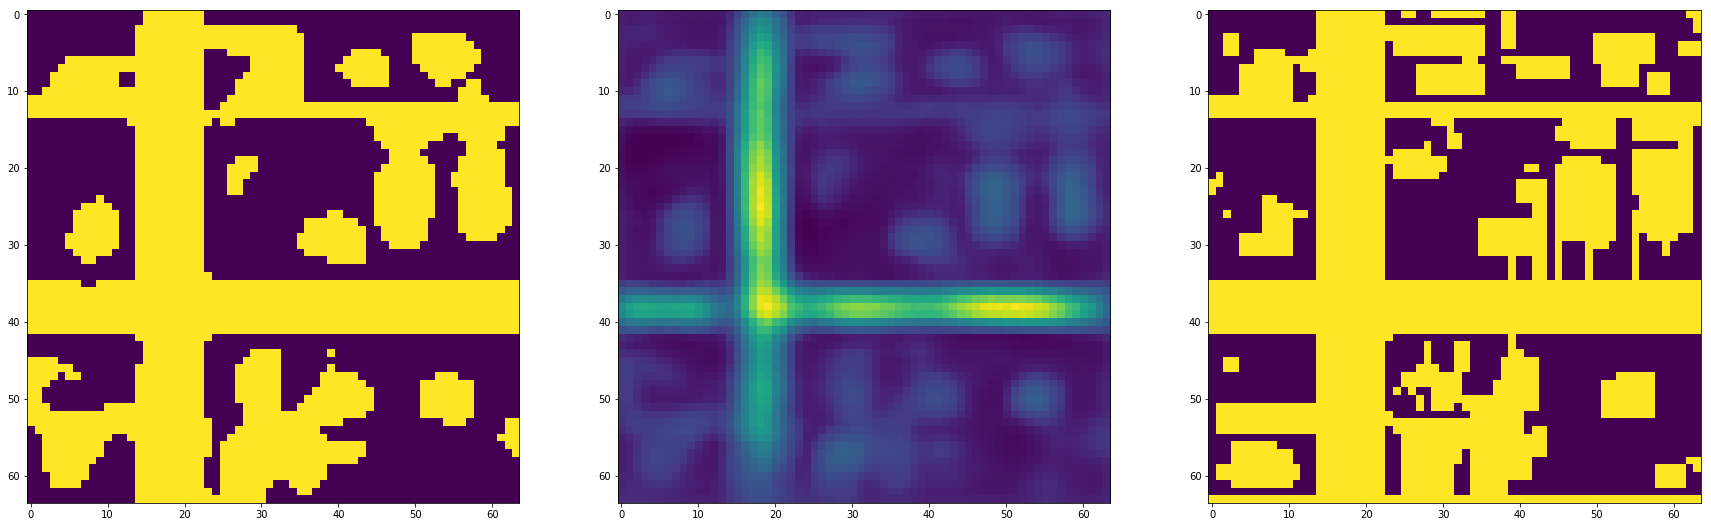

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


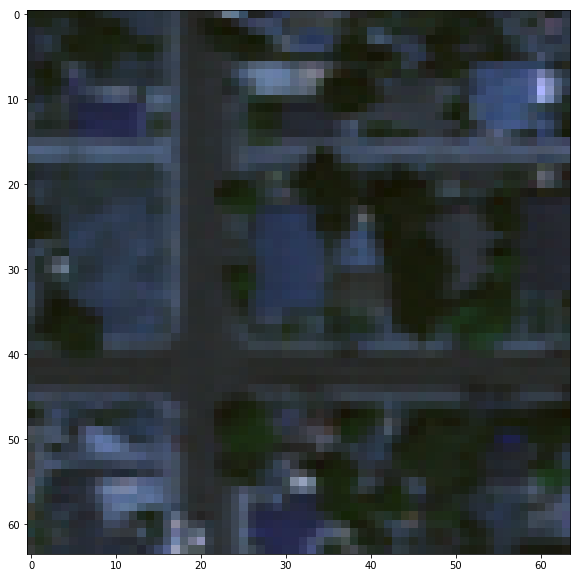

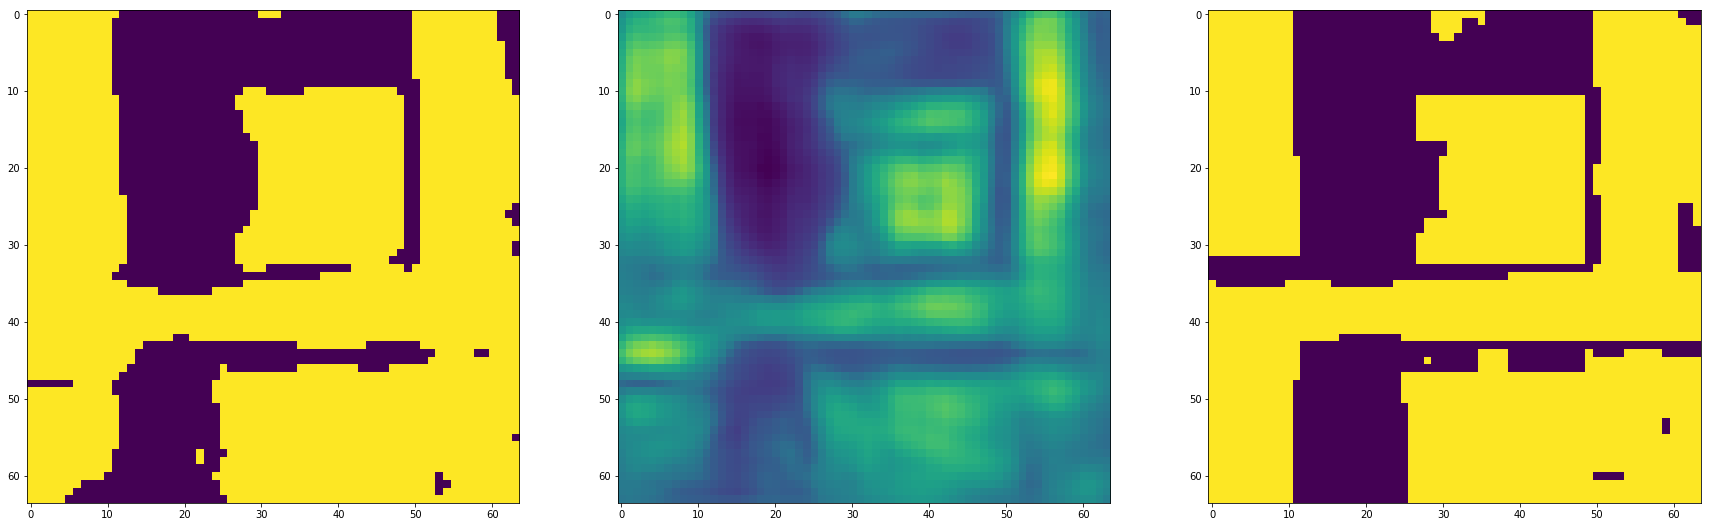

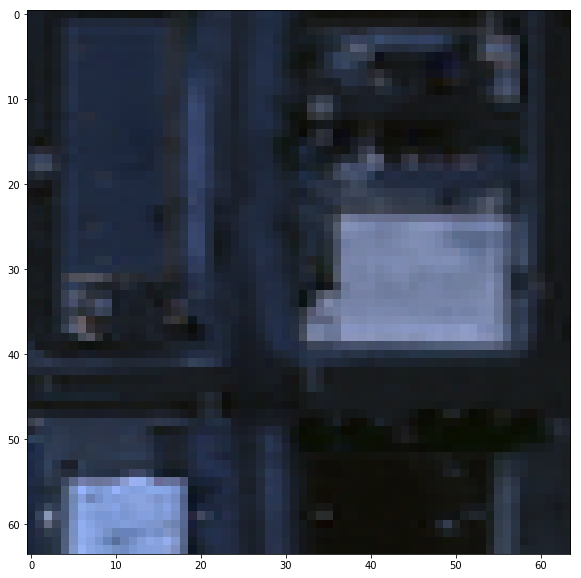

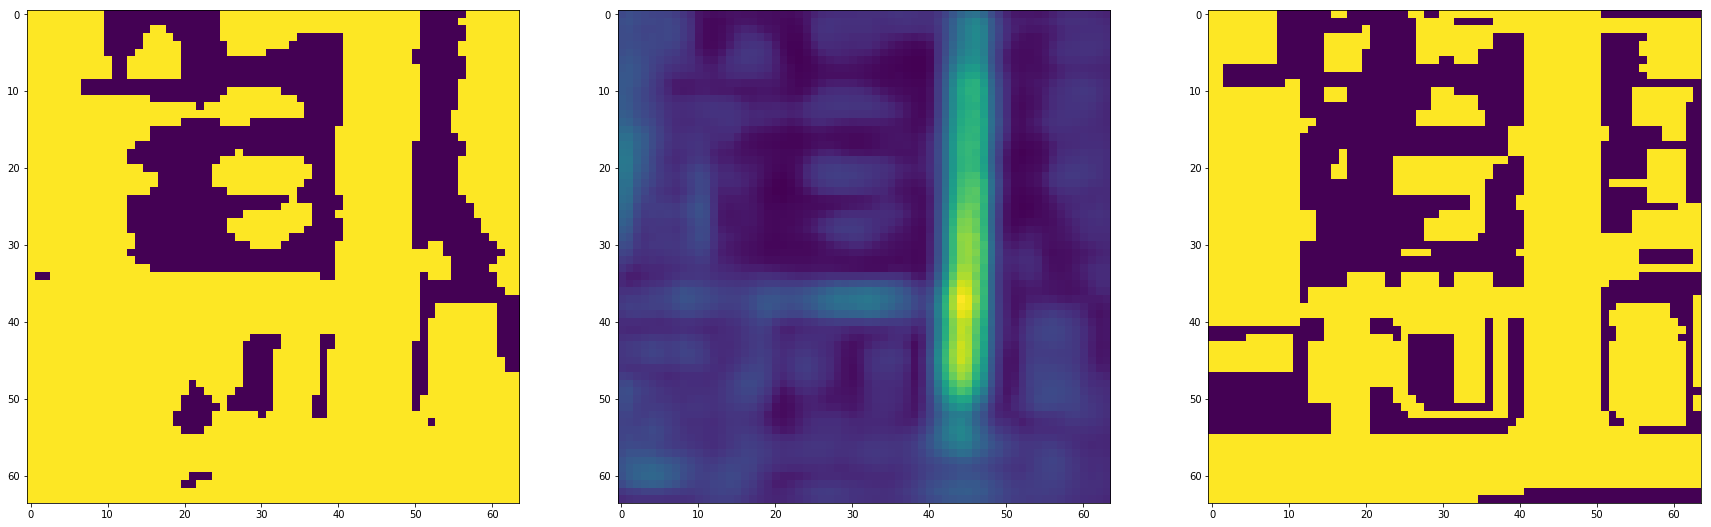

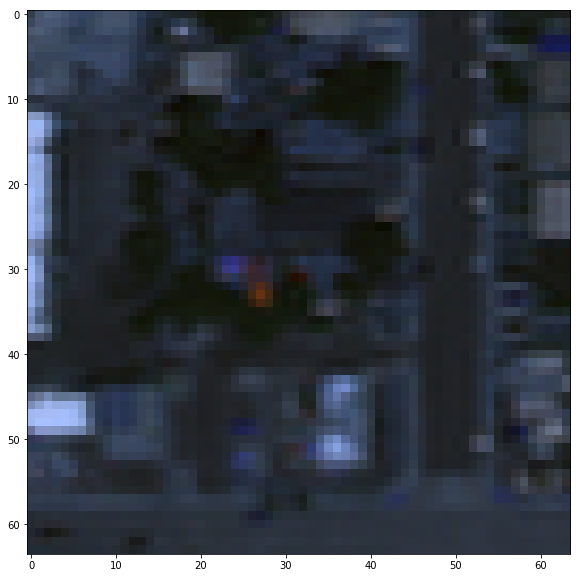

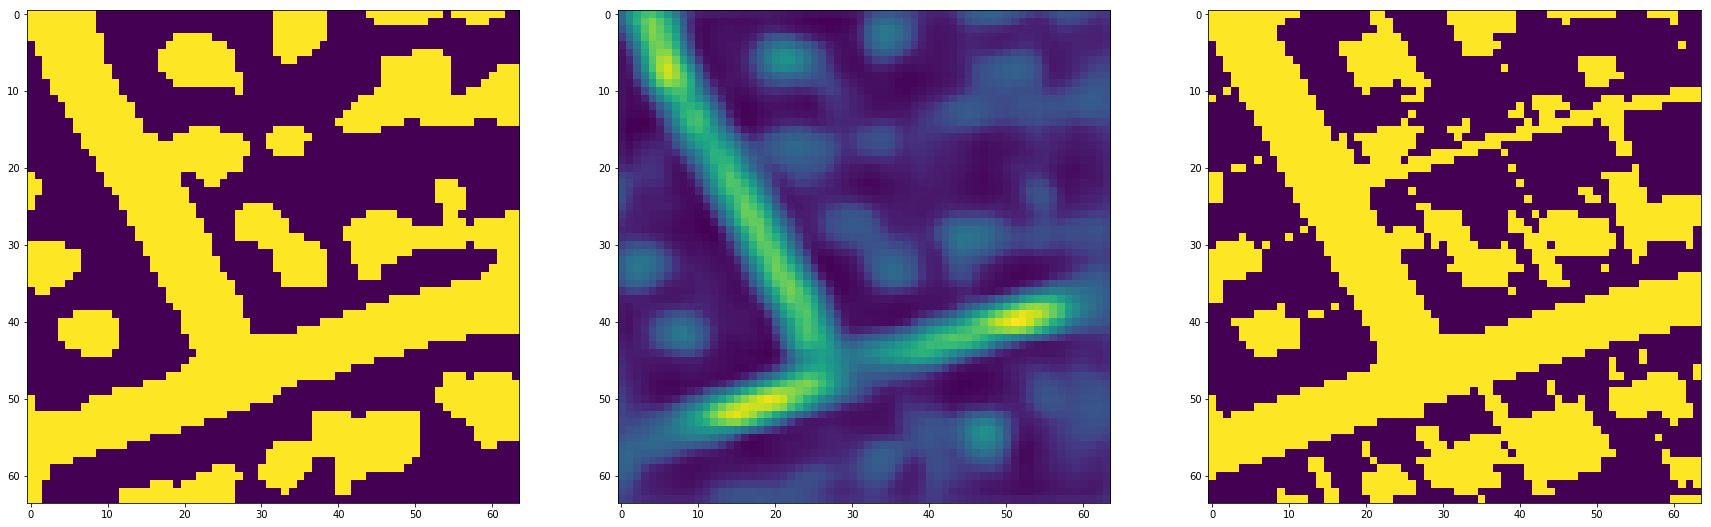

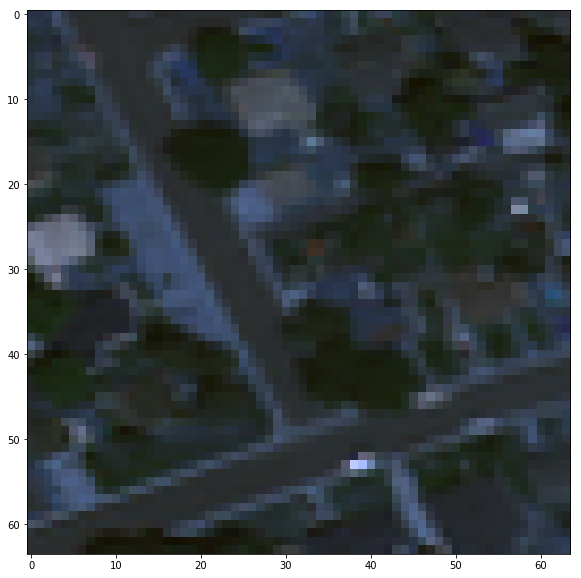

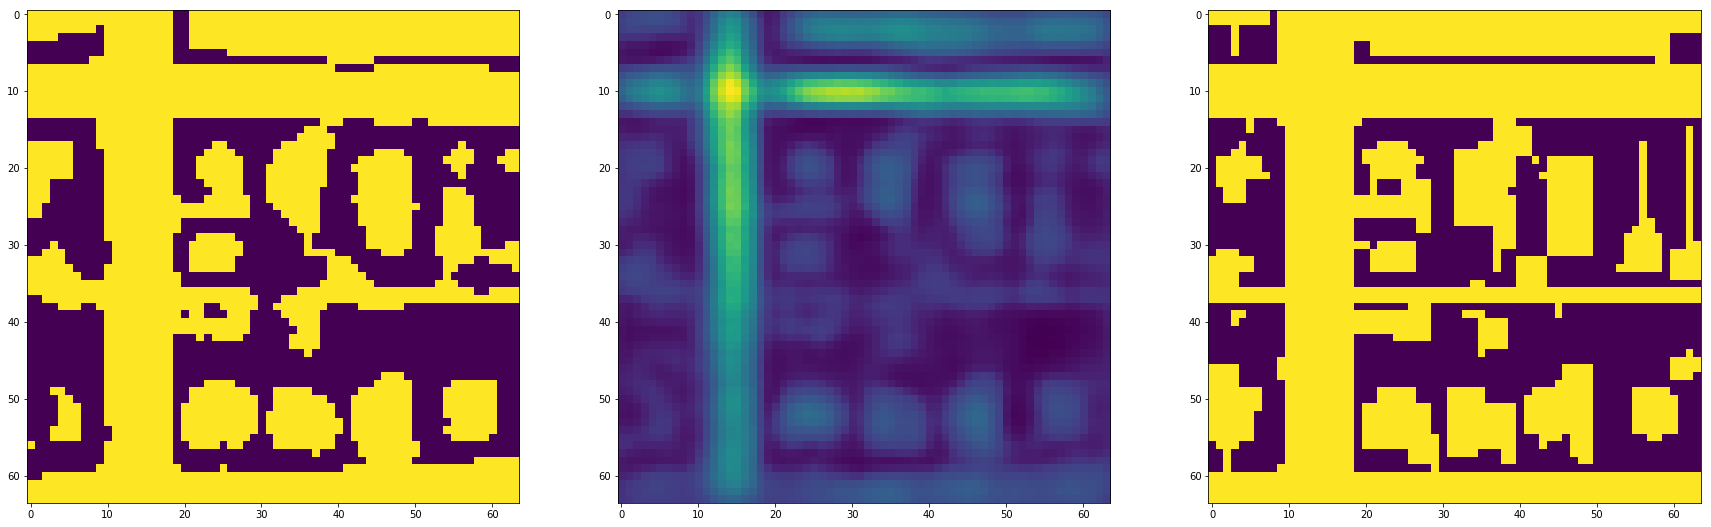

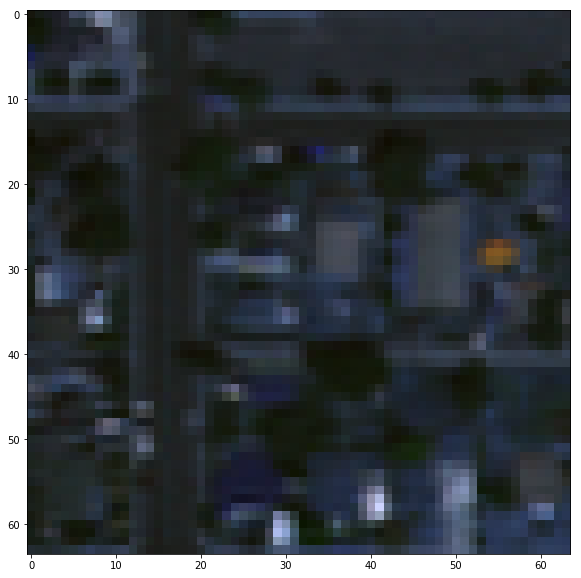

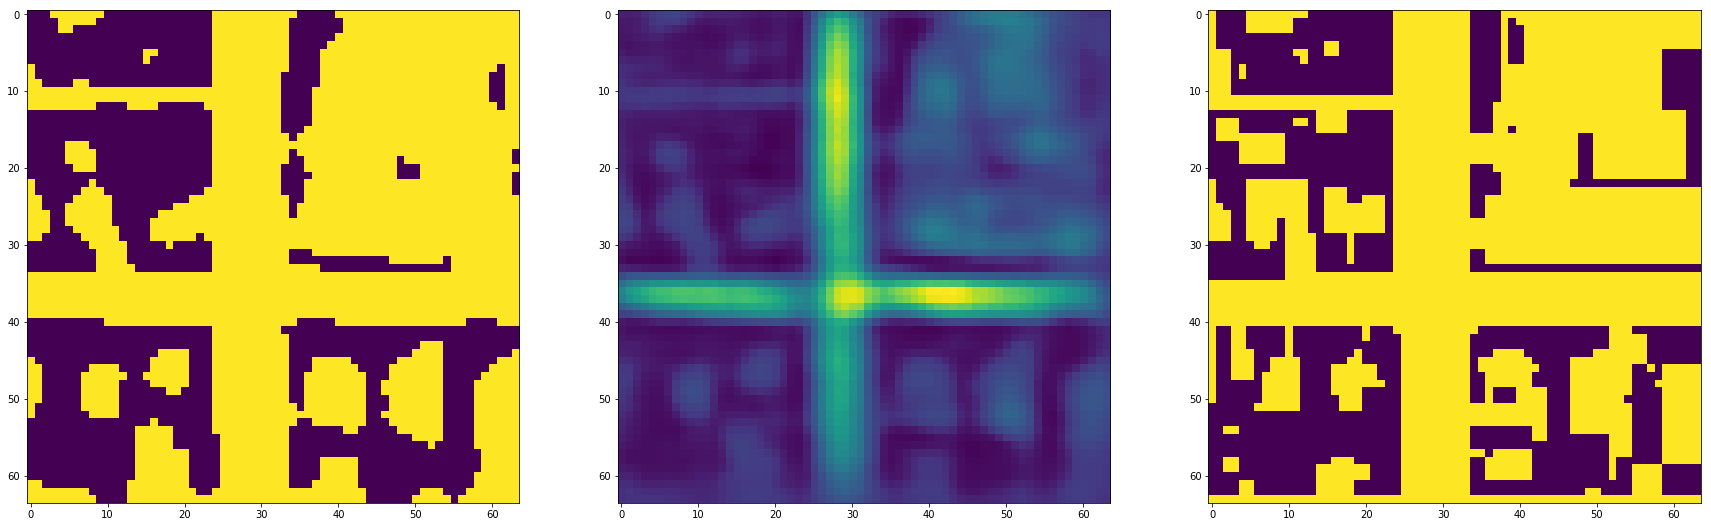

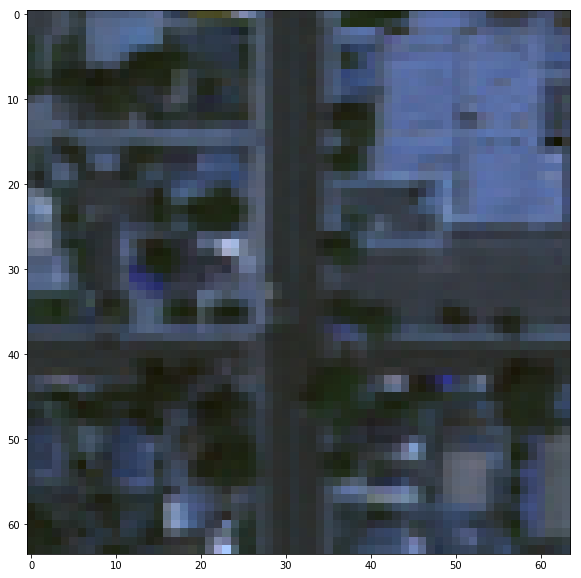

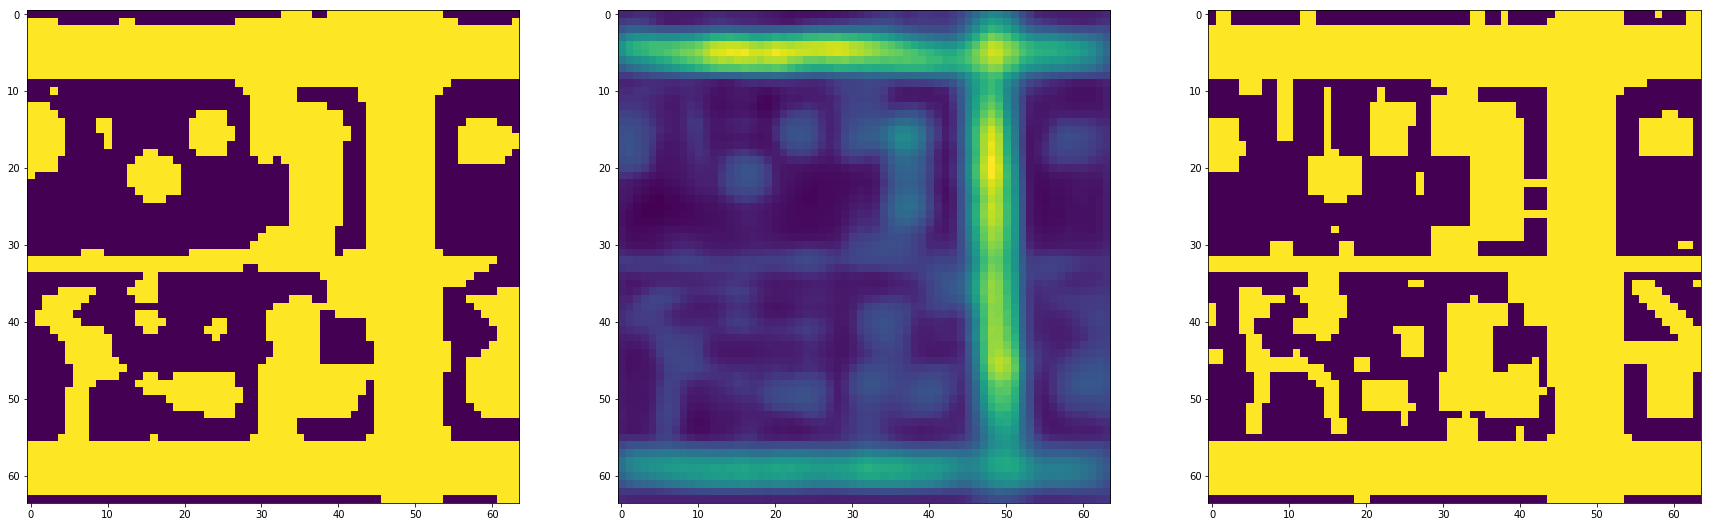

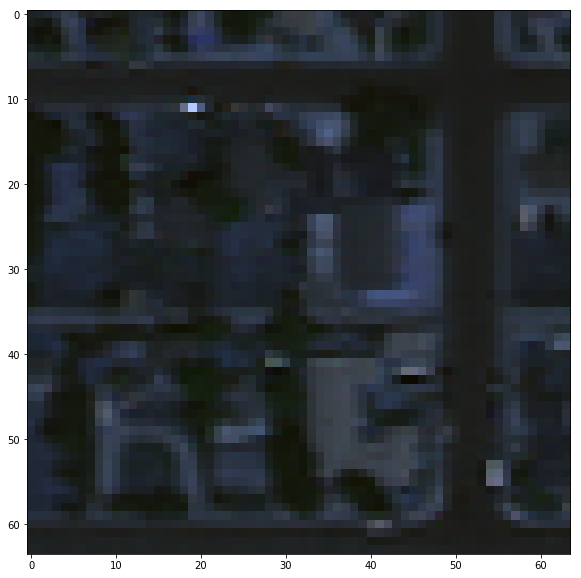

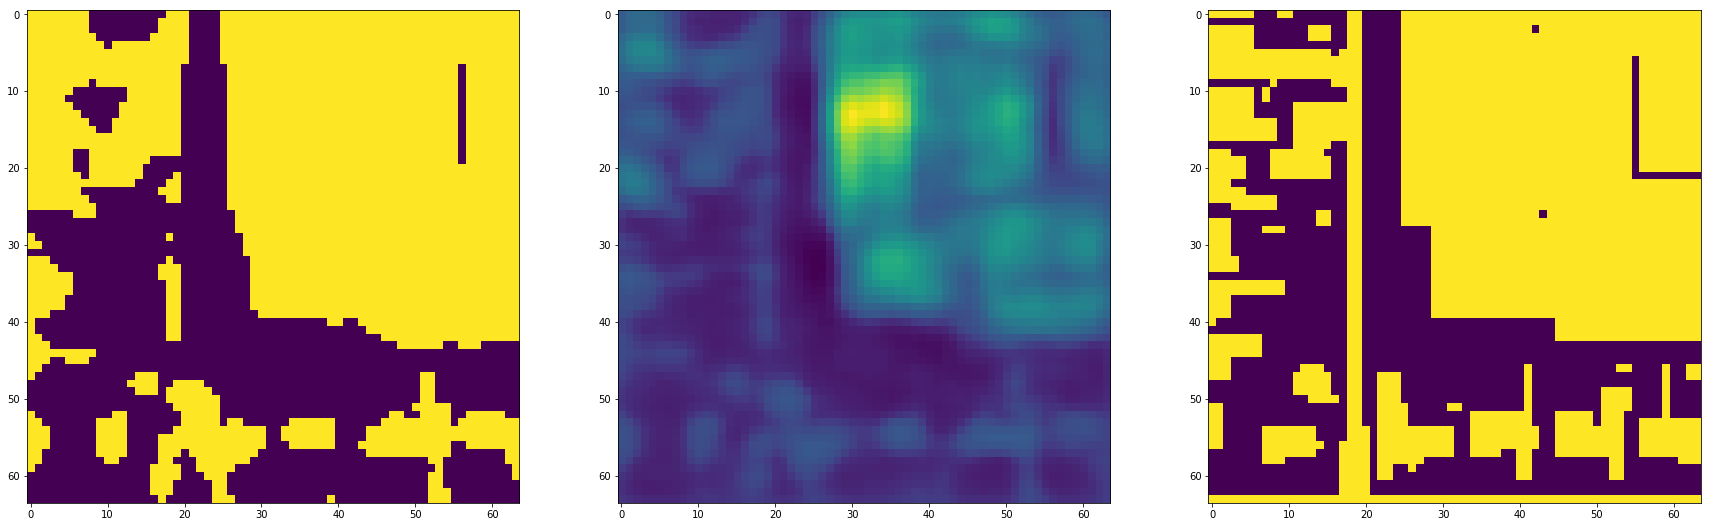

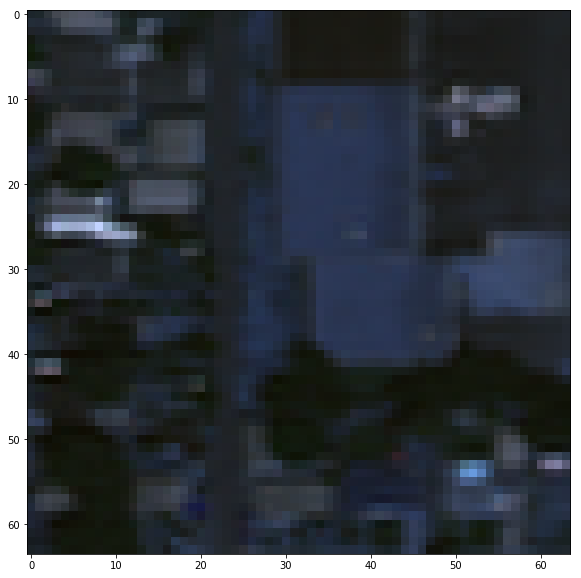

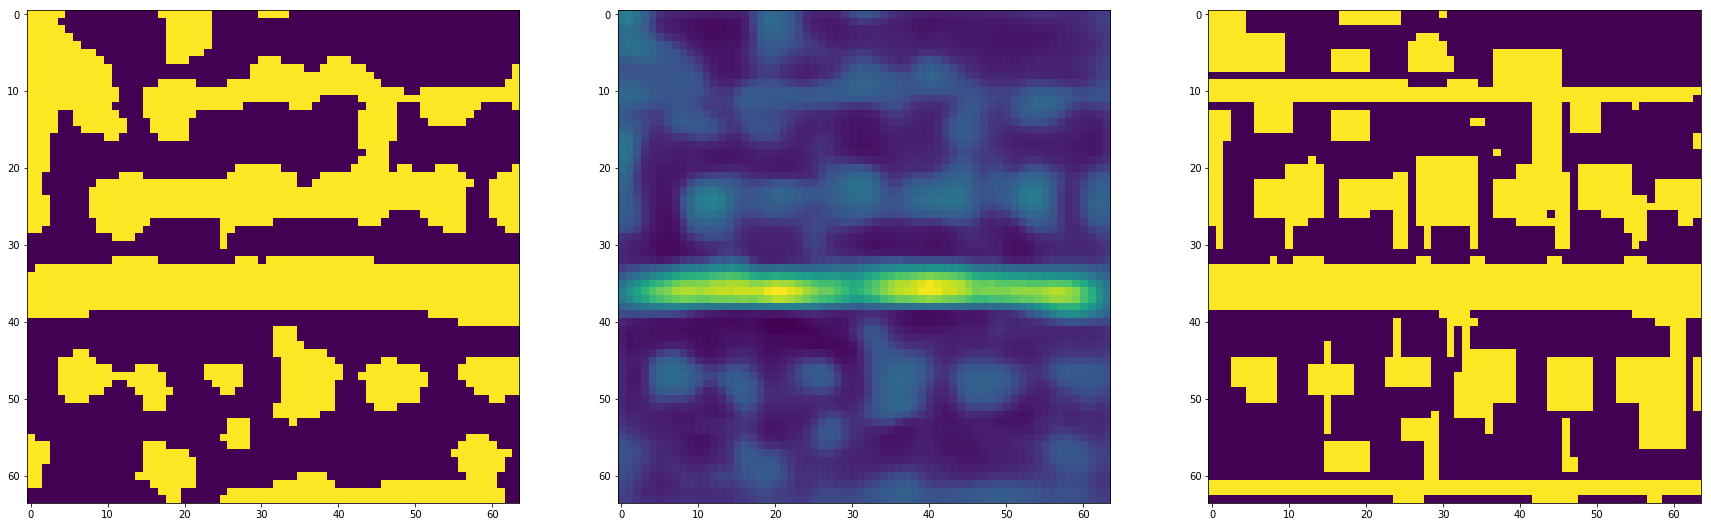

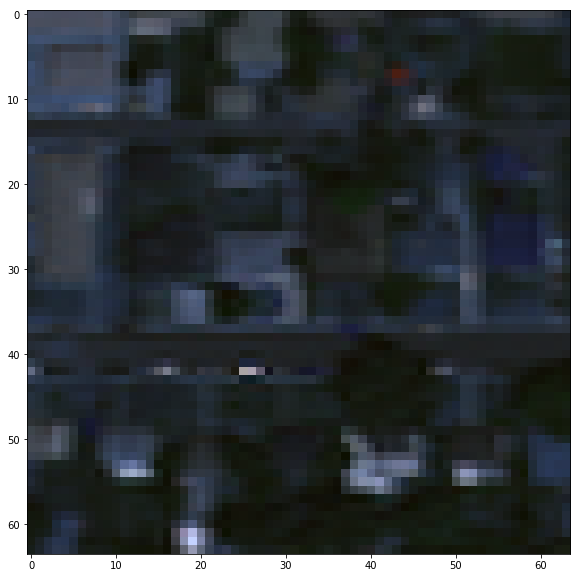

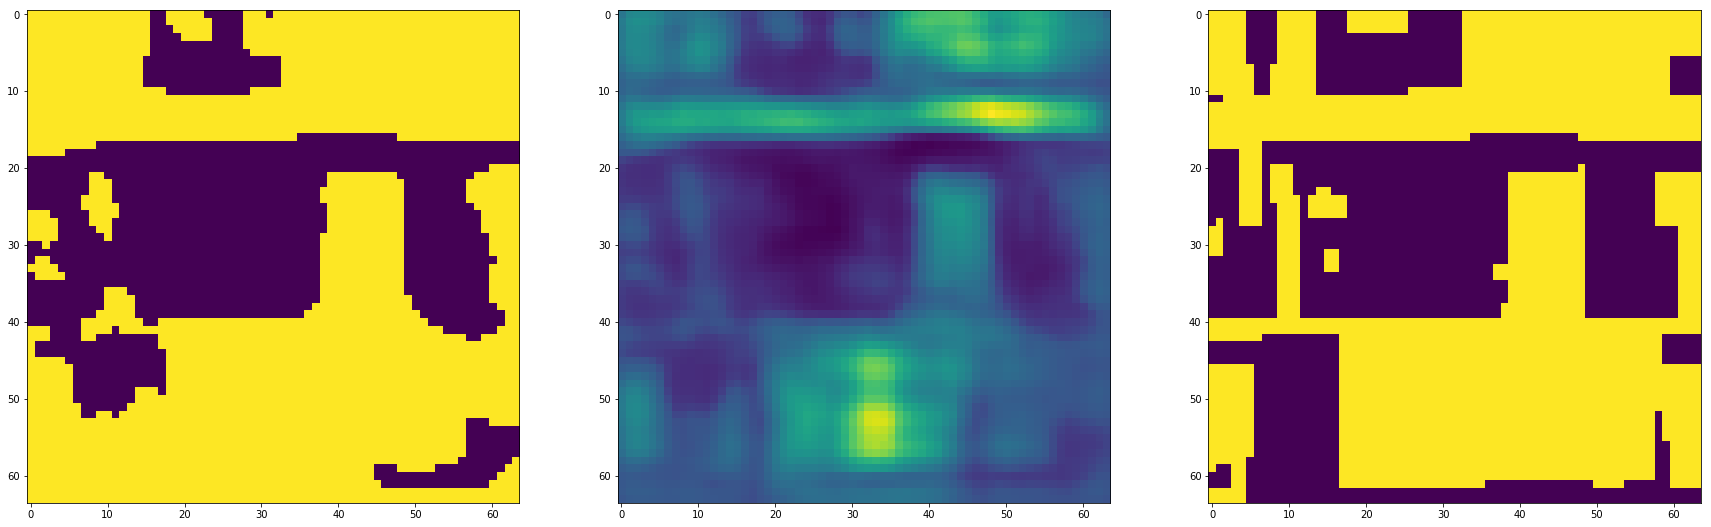

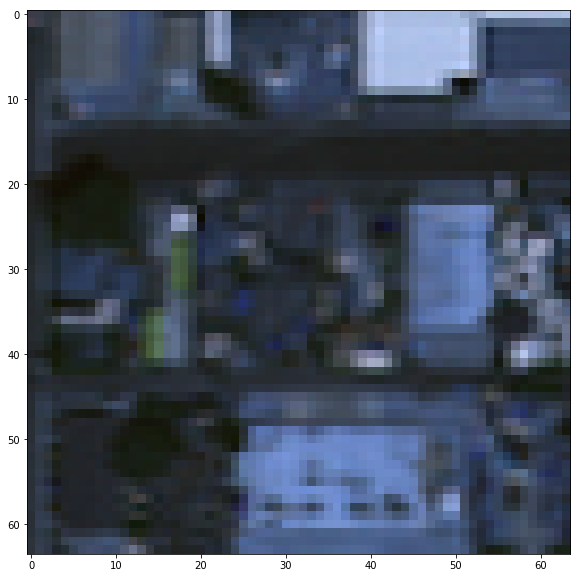

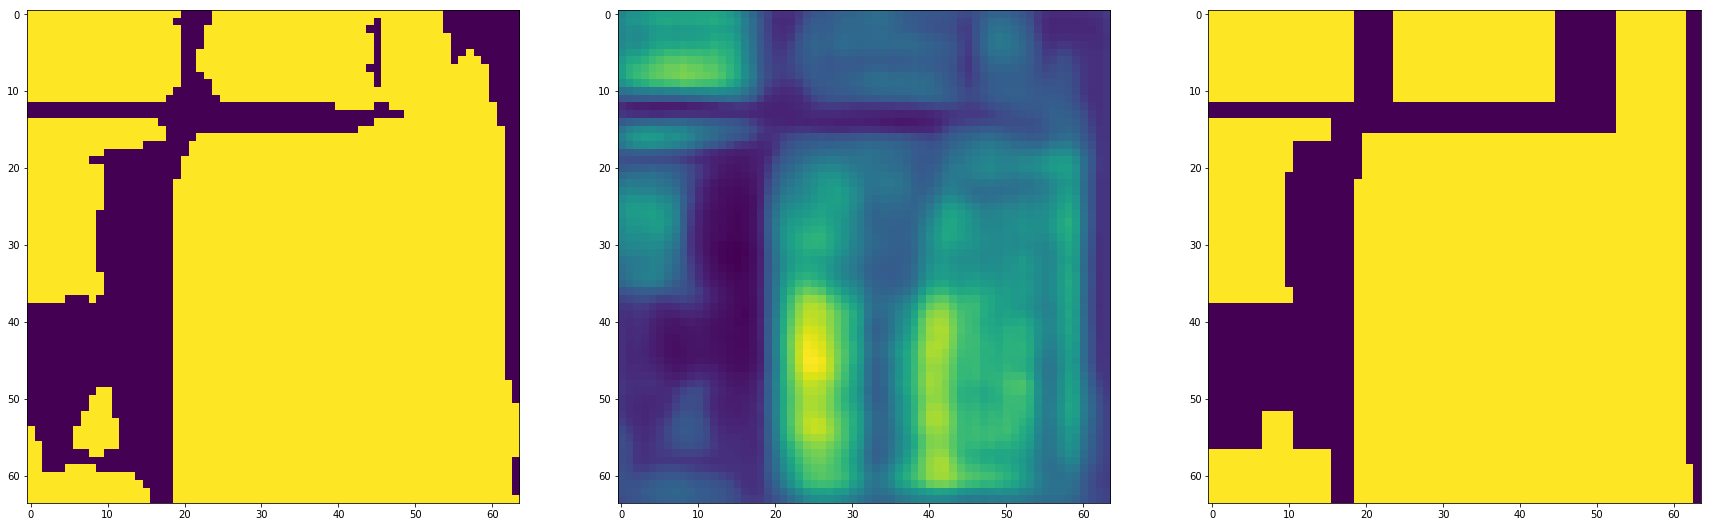

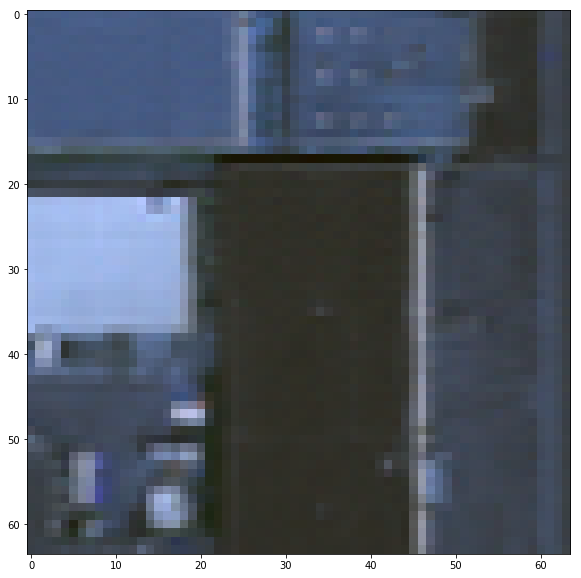

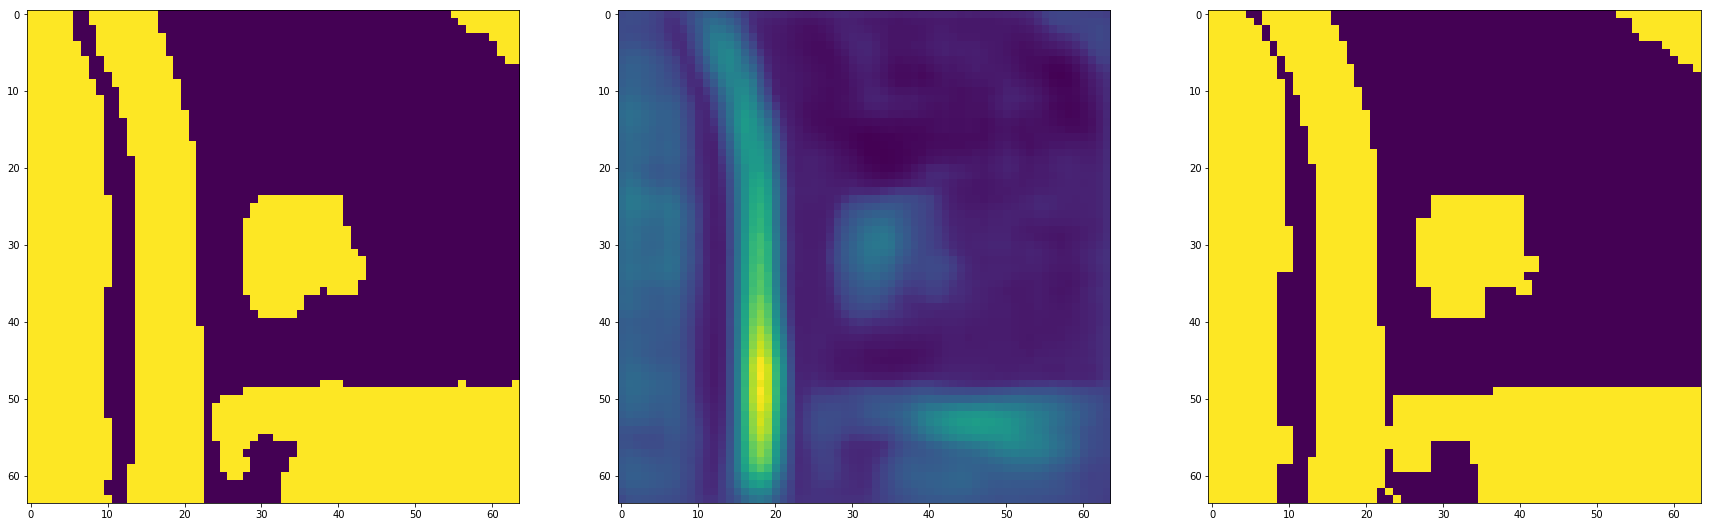

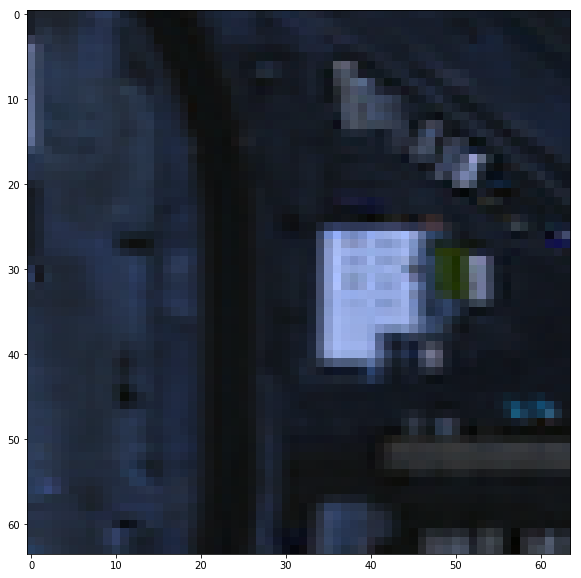

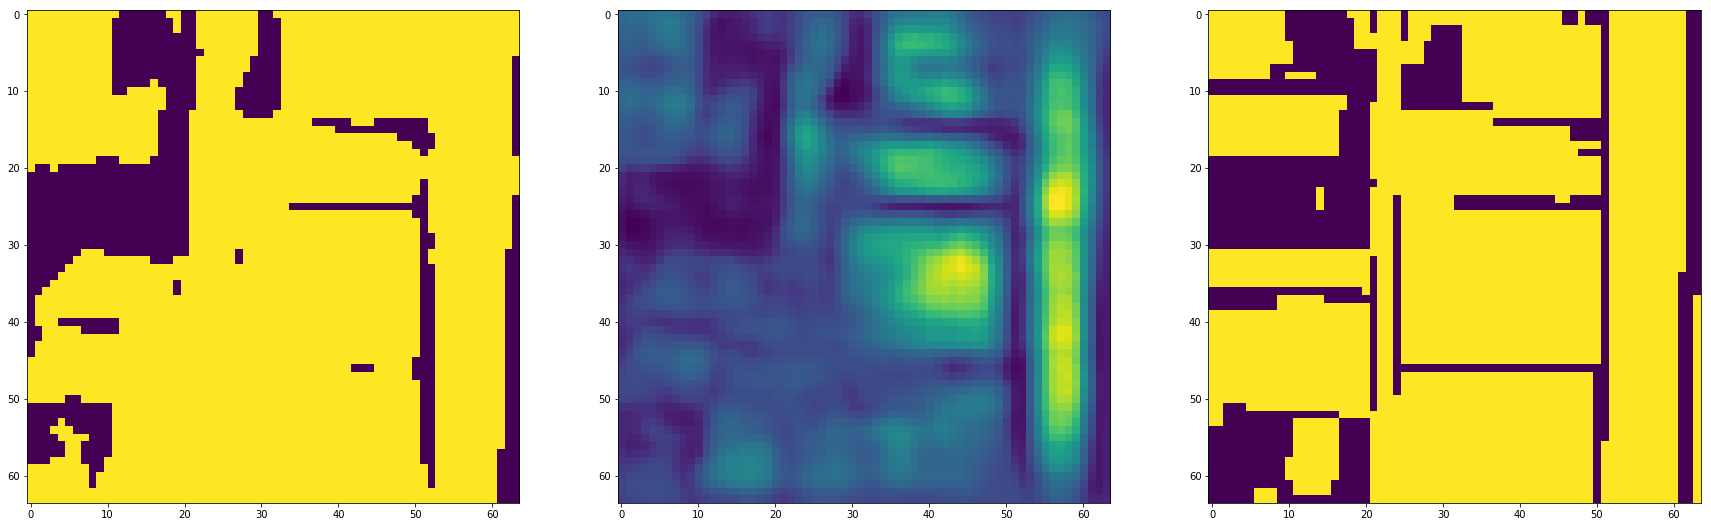

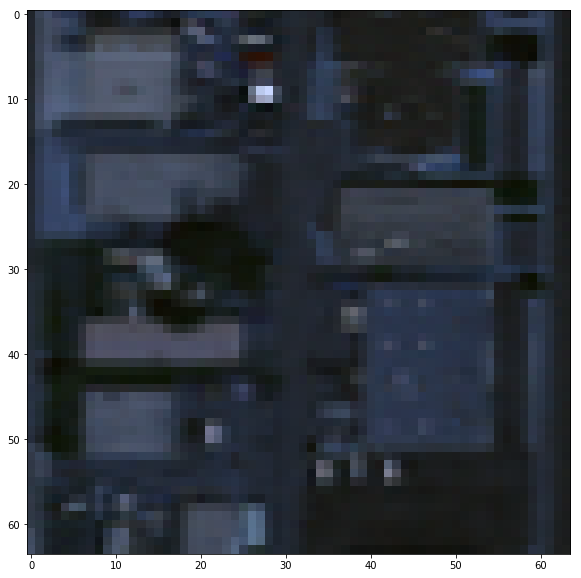

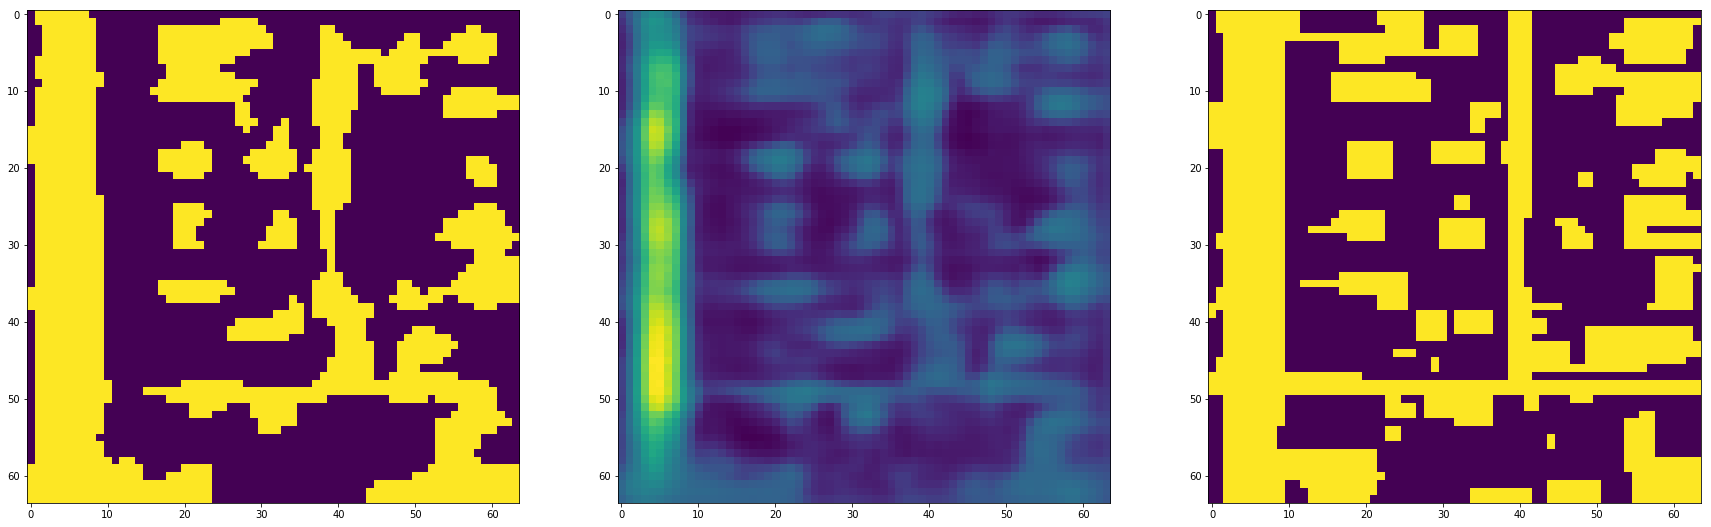

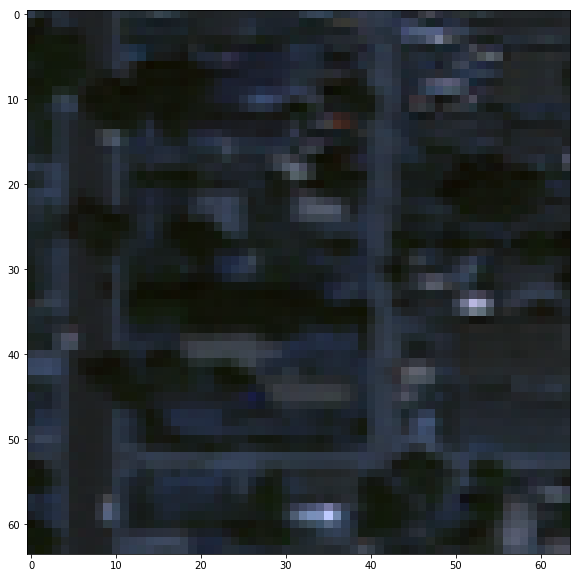

In [23]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
    mask = model(input_img)


    mask_im = mask.squeeze().data.cpu().numpy()
    mask_binary = mask_im.copy()

    fig, ax = plt.subplots(1,3, figsize=(30,10))
    thresh = 0
    mask_binary[mask_im<=thresh] = 0
    mask_binary[mask_im>thresh] = 1
    ax[0].imshow(mask_binary)
    # ax[0].colorbar()
    ax[1].imshow(mask_im)
    gt_im = gt_dataset_test[test_ind].numpy().squeeze()
    ax[2].imshow(gt_im)
    # ax[1].colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,10))
    source_im = dg_dataset_test[test_ind].numpy()
    plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
    plt.show()



In [24]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [25]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [26]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))